# 0.0. IMPORTS

In [82]:
import pandas as pd
import numpy as np
import inflection
import math

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from tabulate import tabulate
from scipy import stats as ss
 
from IPython.core.display import HTML
from IPython.display import Image

import datetime


## 0.1 Helper Functions

In [117]:
def cramer_v (x ,y):

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1)) )



def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()

In [118]:
jupyter_settings()

## 0.2 Loading Data

In [32]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. PASSO 02 - DESCRICAO DOS DADOS

In [33]:
df1 = df_raw.copy()

## 1.1 Rename

In [34]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [35]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [36]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [37]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [38]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [39]:
df1['competition_distance'].max()

75860.0

In [40]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month   
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                       
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval           
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'July', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']== 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


## 1.6 Change Type

In [41]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [42]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [43]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [44]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


### 1.7.2 Categorical Attributes

In [45]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

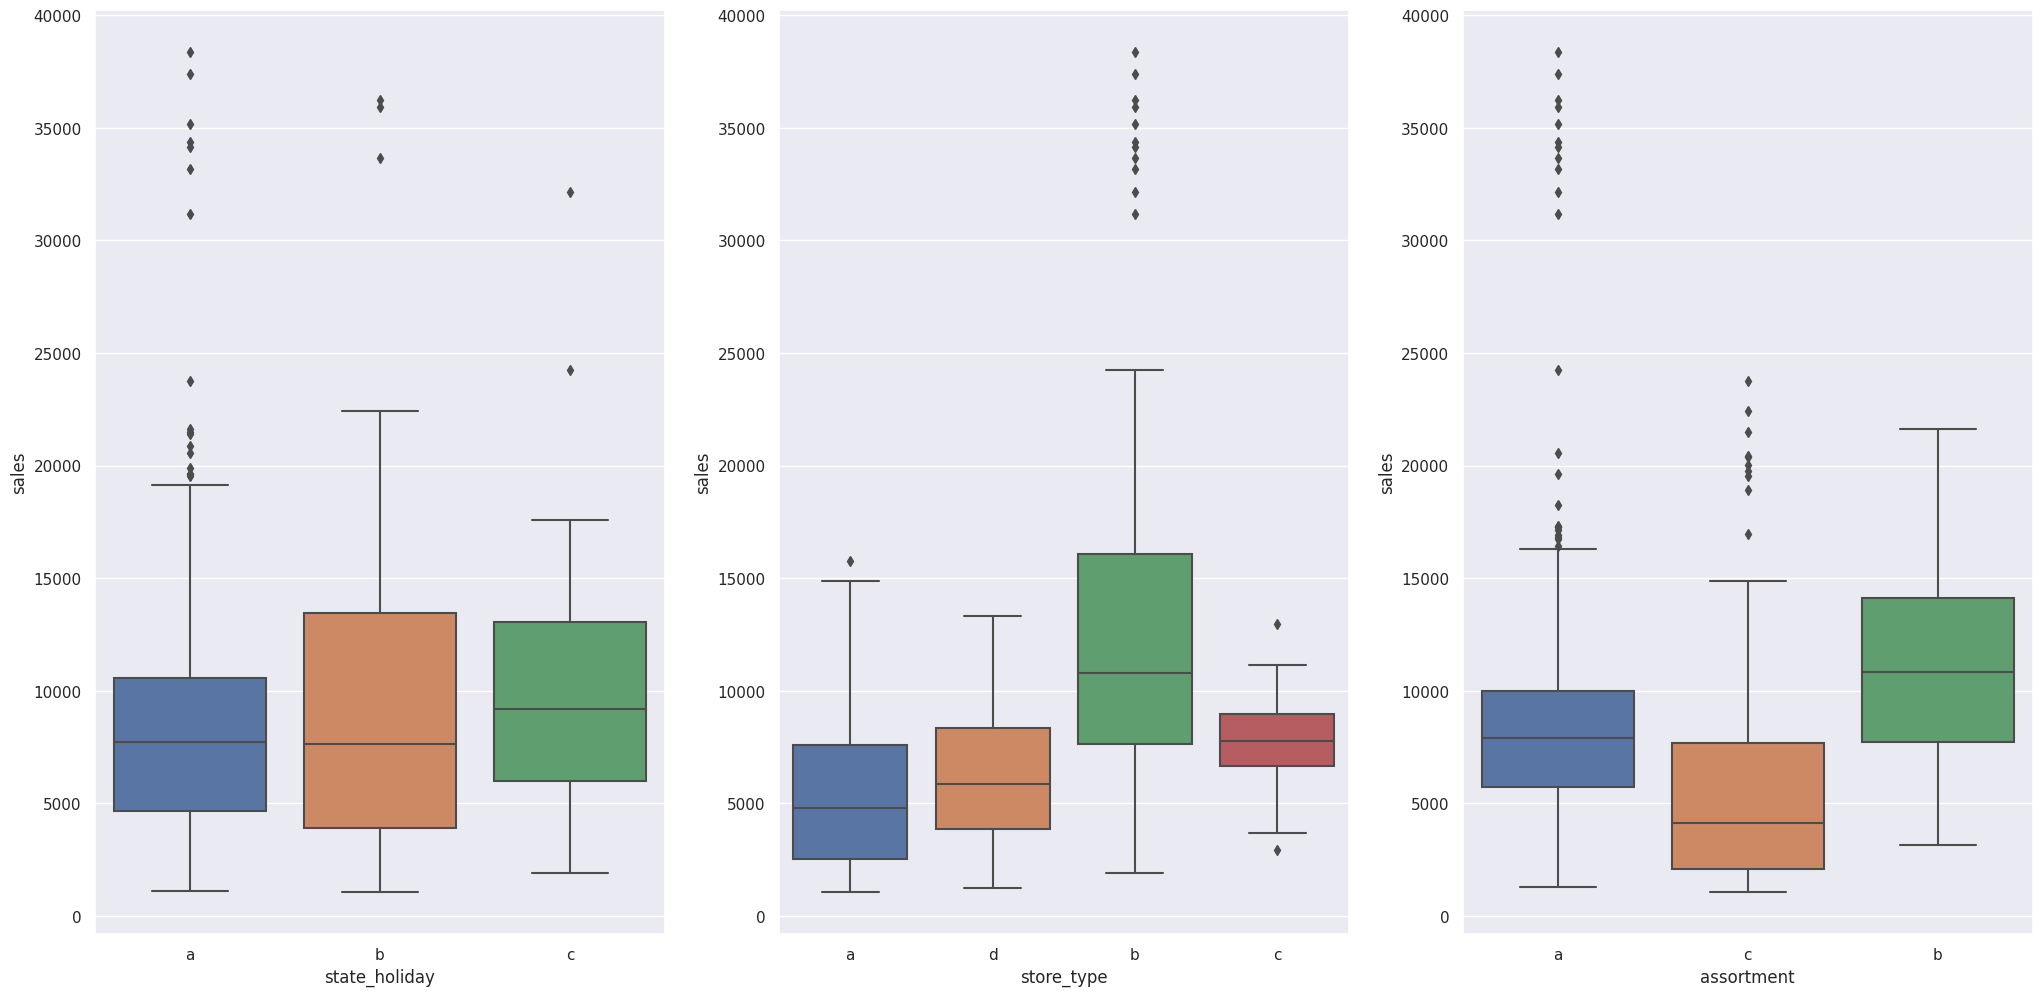

In [46]:
aux1 = df1[(df1['state_holiday']!='0') & df1['sales']>0]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1);

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [47]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

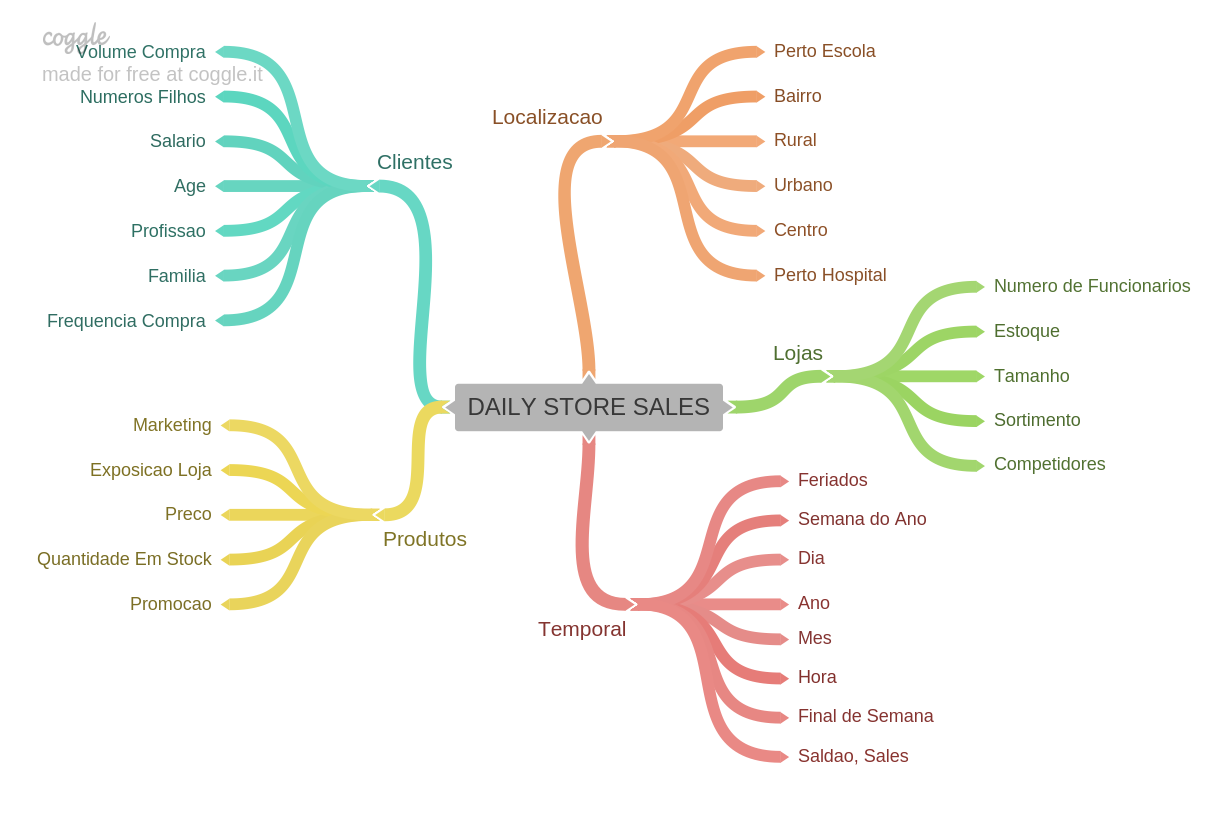

In [48]:
Image('img/MindMapHypothesis.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [49]:
#Year
df2['year'] = df2['date'].dt.year

#Month
df2['month'] = df2['date'].dt.month

#Day
df2['day'] = df2['date'].dt.day

#Week of Year
df2['week_of_year'] = df2['date'].dt.weekofyear

#Year Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#Competition Since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_since_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#State Holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')



/tmp/ipykernel_5113/2830964497.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 PASSO 03 - FILTRAGEM DAS VARIÁVEIS

In [50]:
df3 = df2.copy()

In [51]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_since_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.00,9,2008,0,31,2015,0,July,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.00,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",July,0,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",July,0,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.00,9,2009,0,31,2015,0,July,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.00,4,2015,0,31,2015,0,July,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [52]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

## 3.2 Seleção das Colunas

In [53]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

In [54]:
df3 = df3.drop(cols_drop, axis=1)

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS

In [55]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

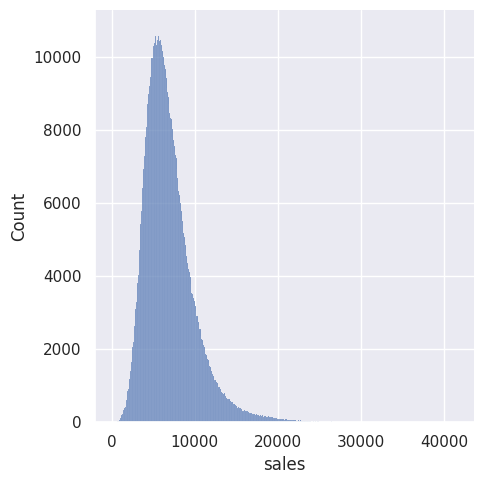

In [56]:
sns.displot(df4['sales']);

### 4.1.2 Numerical Variabel

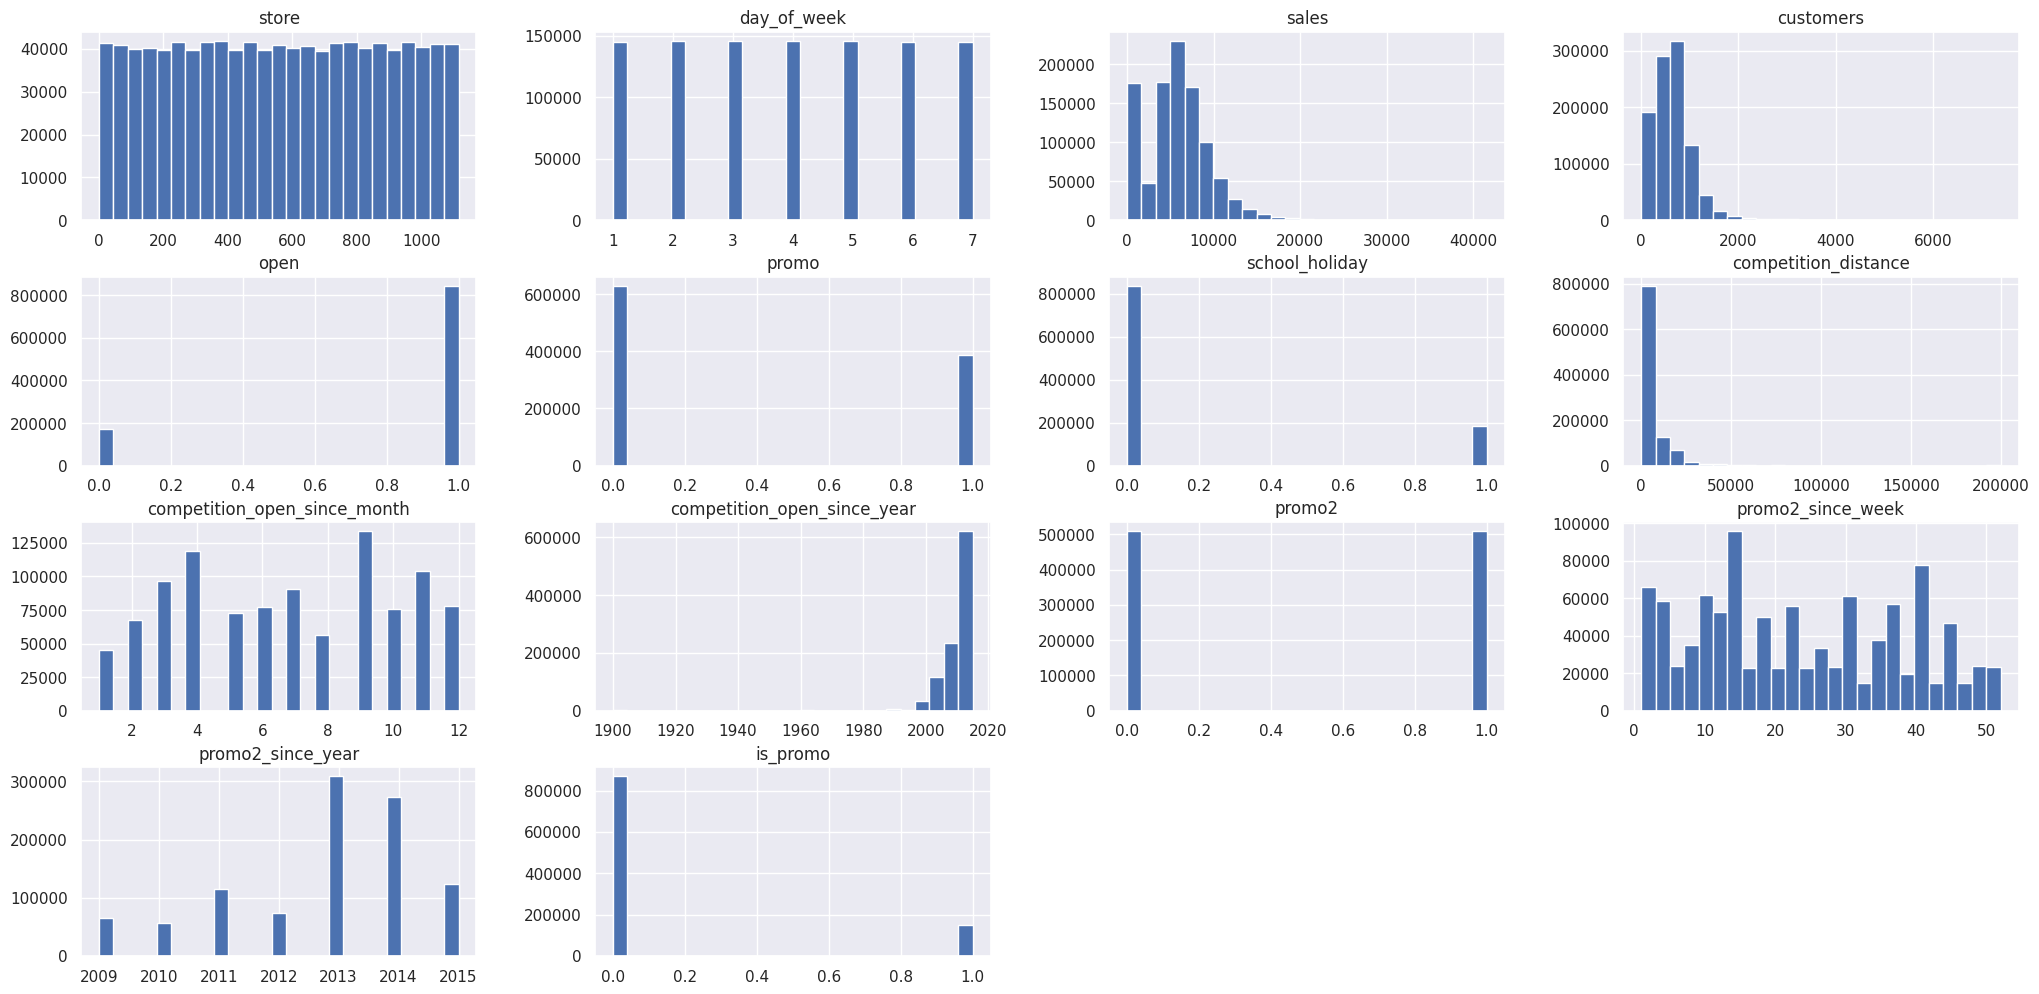

In [57]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

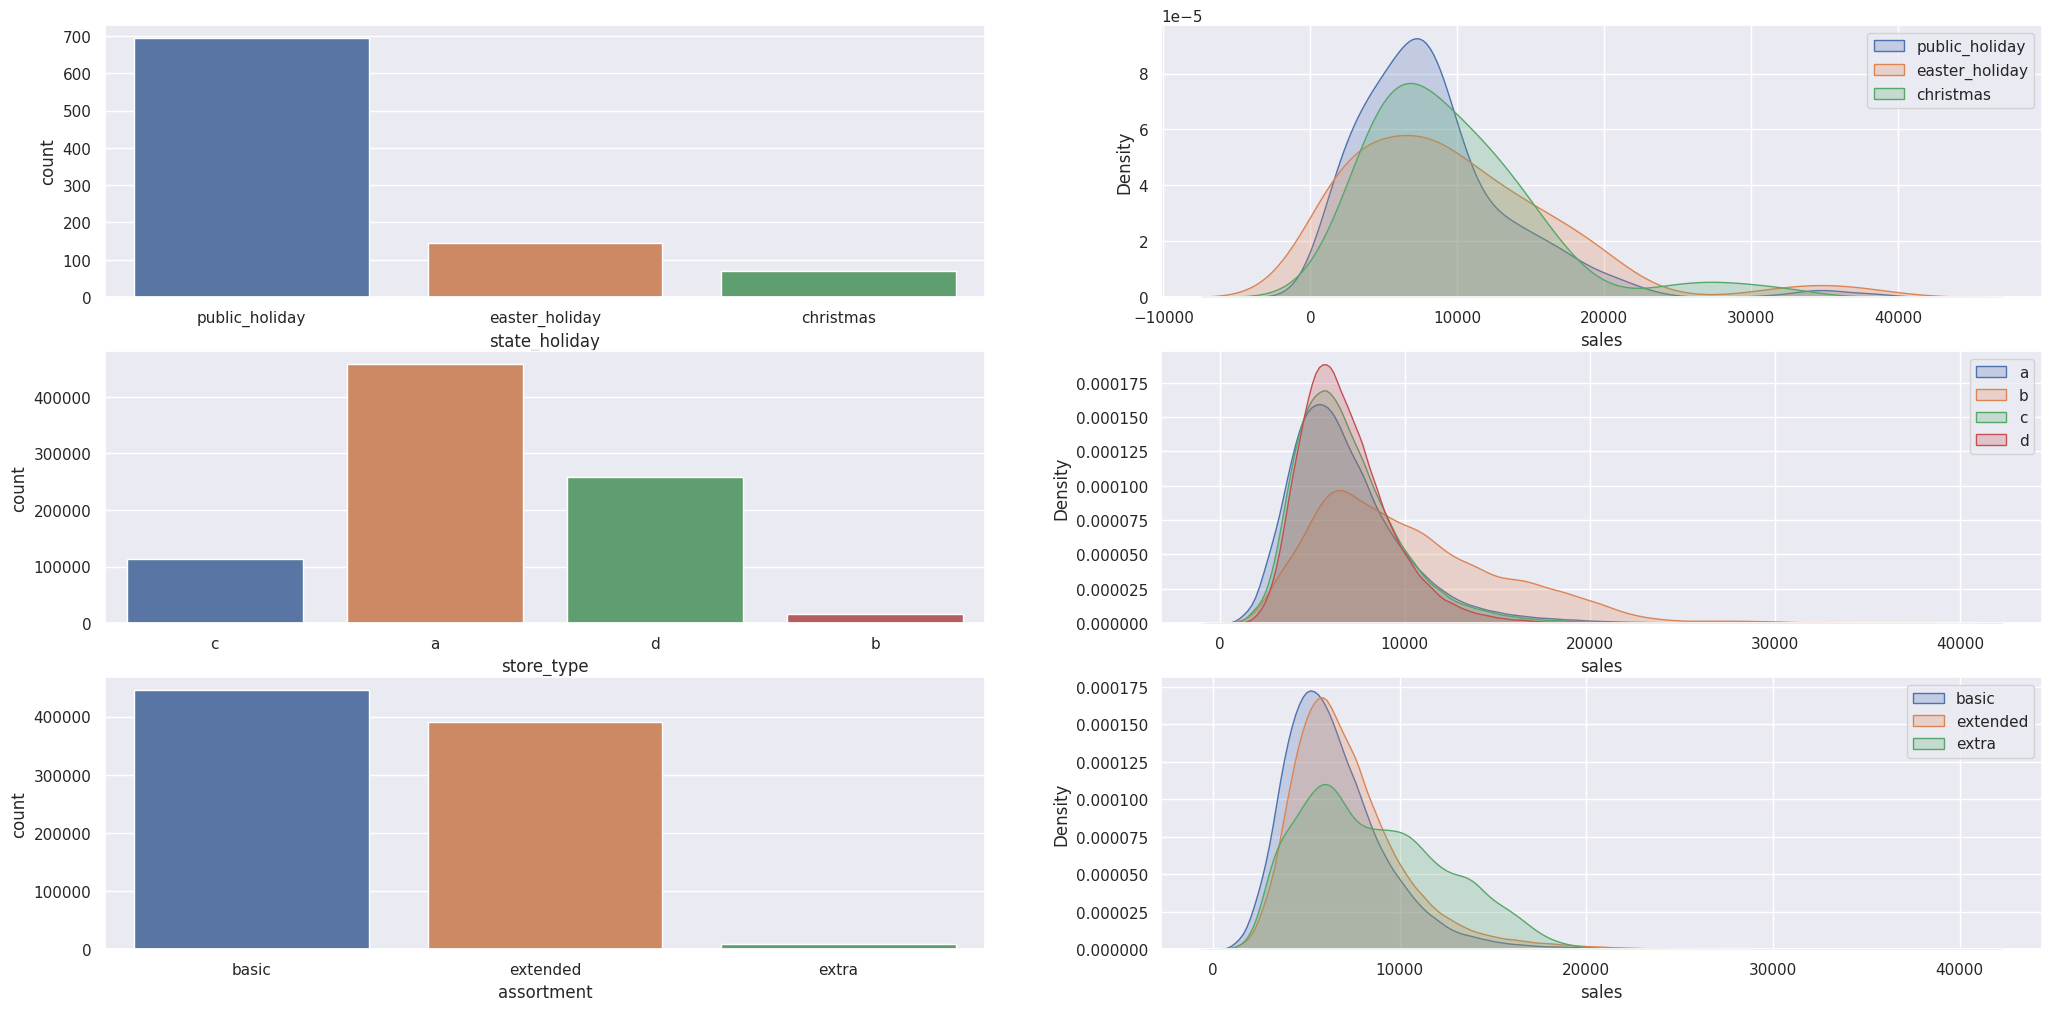

In [58]:
#state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday']!='regular_day']
sns.countplot(x = a['state_holiday'])


plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], label='christmas', fill=True)
plt.legend()


#store_type
plt.subplot(3,2,3)
sns.countplot(x=df4['store_type'])


plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label='d', fill=True)
plt.legend()


#assortment
plt.subplot(3,2,5)
sns.countplot(x=df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], label='basic', fill='true')
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label='extended', fill='true')
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], label='extra', fill='true')
plt.legend()




## 4.2 Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

***FALSA** Lojas com MAIOR sortimento vende MENOS

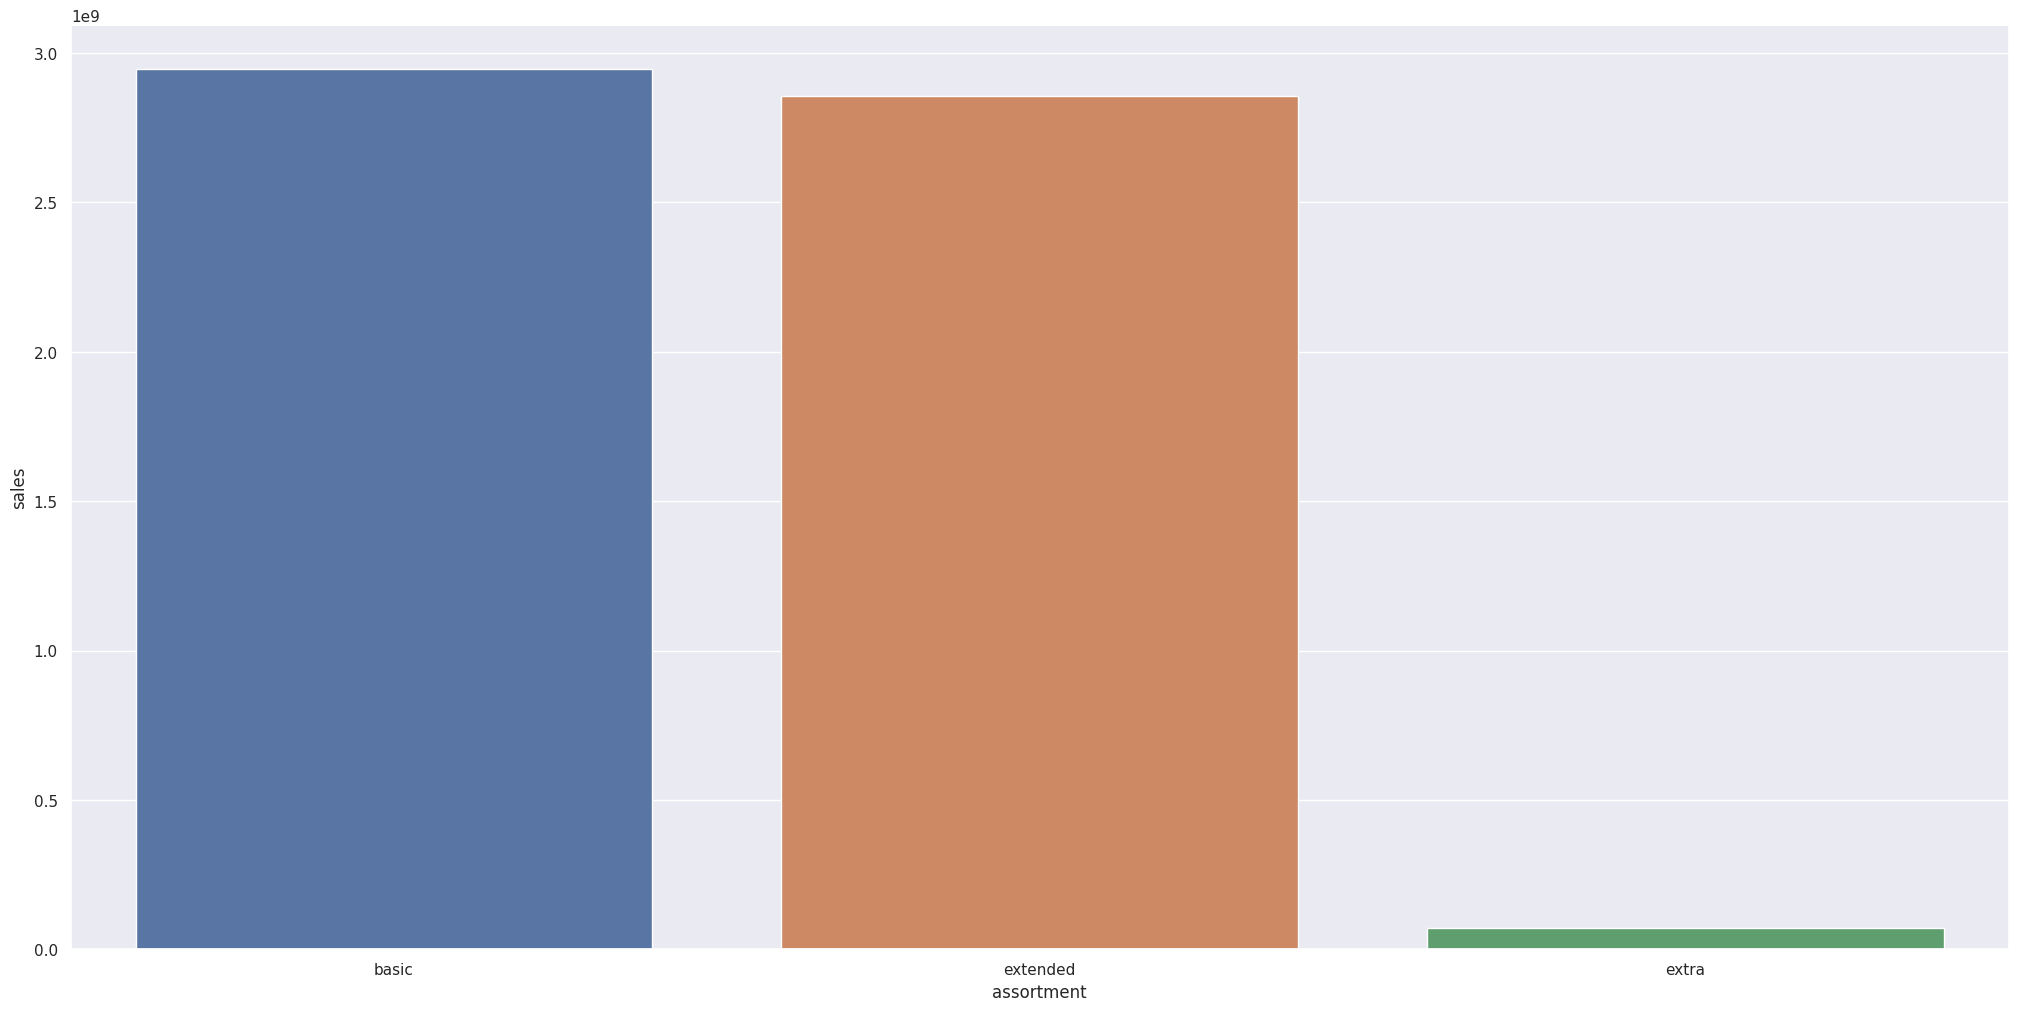

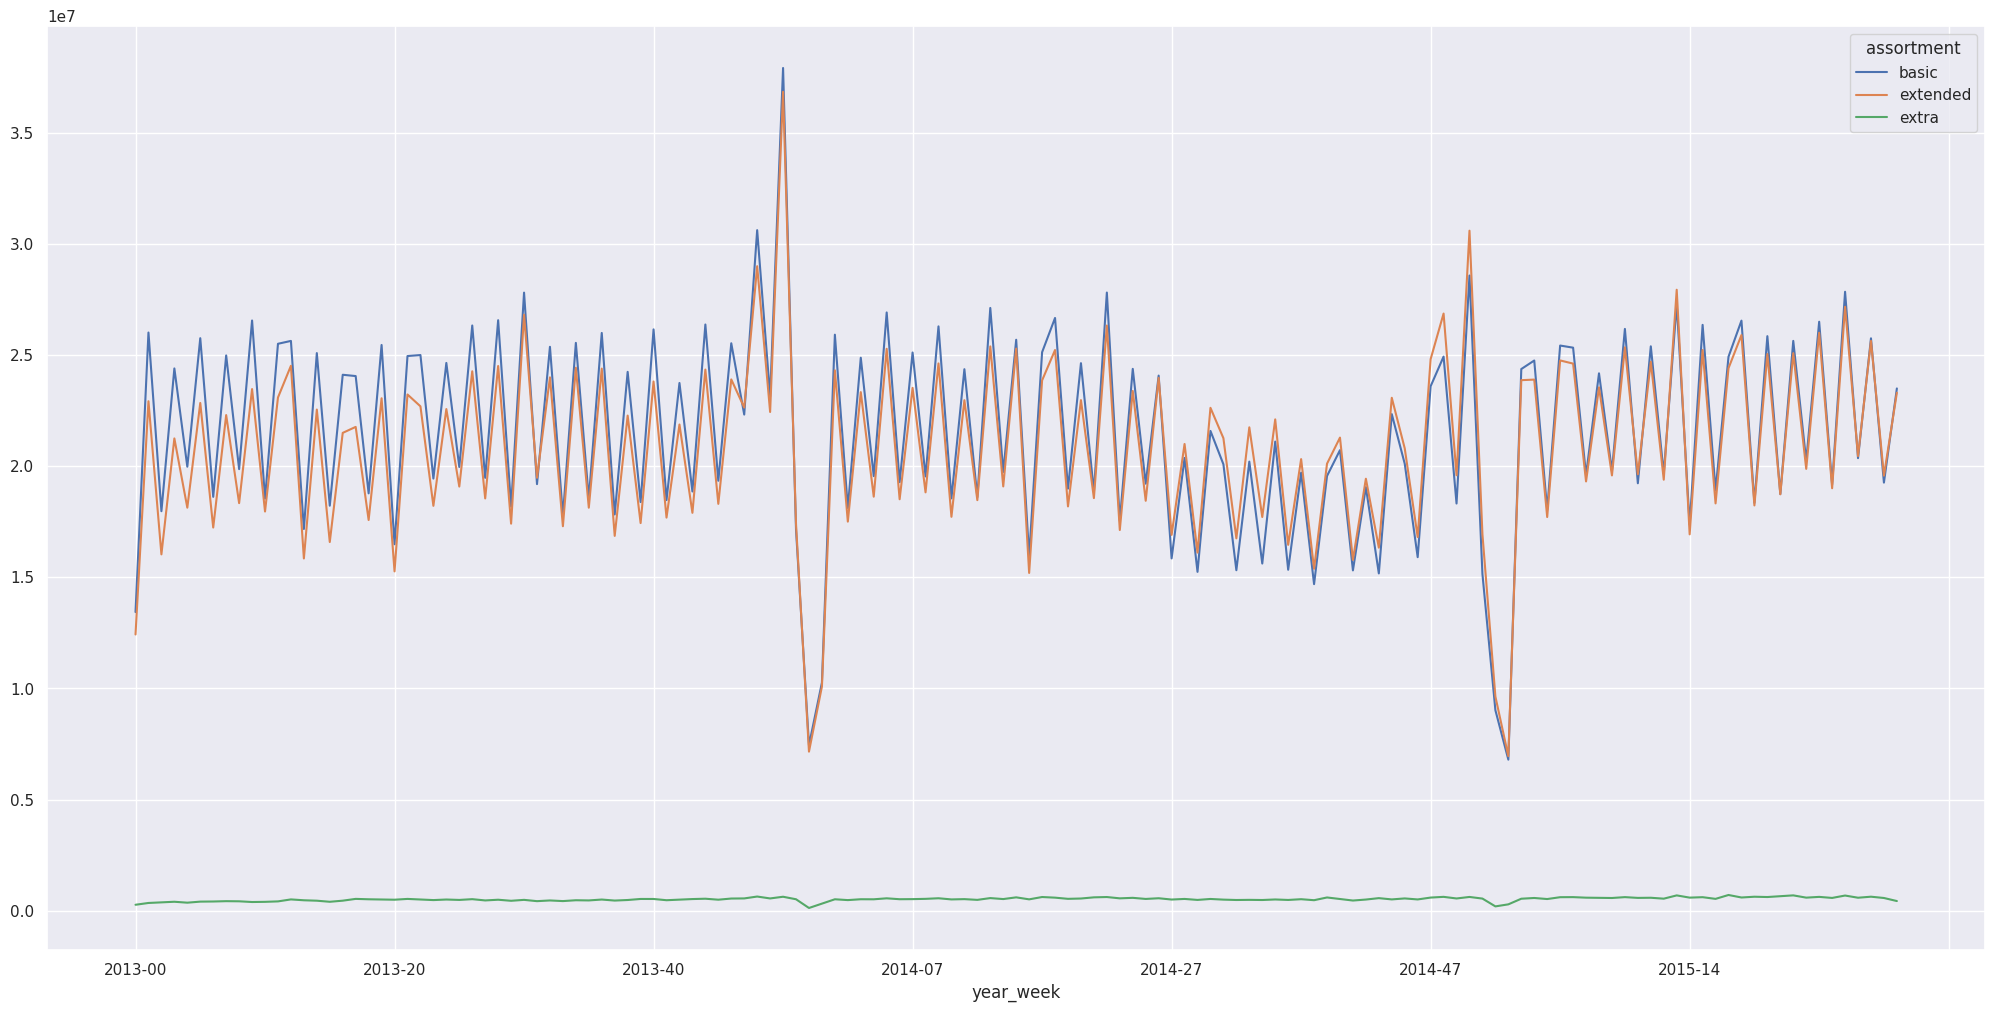

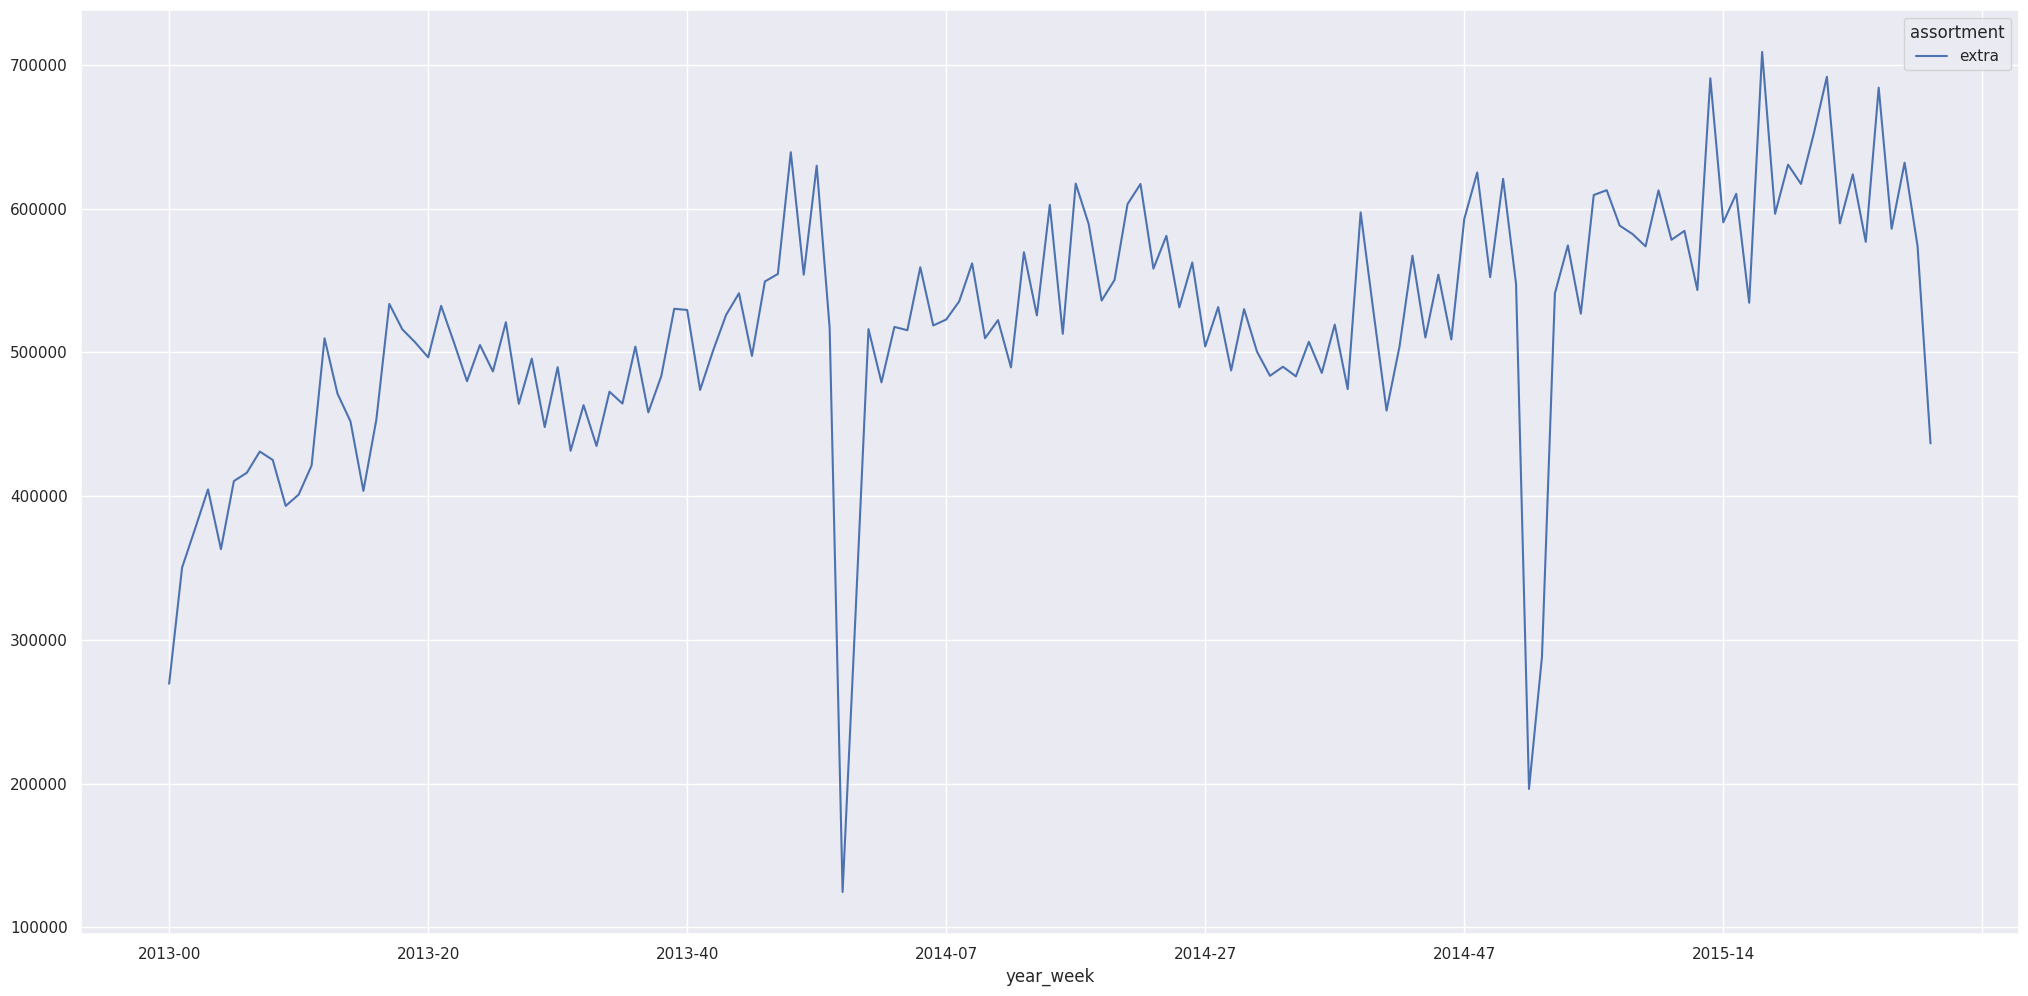

In [59]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data = aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2. Lojas com competidores mais próximos deveriam vender menos.
 ***FALSA**. Lojas com competidores MAIS próximos vendem MAIS


/tmp/ipykernel_5113/2391953163.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True);


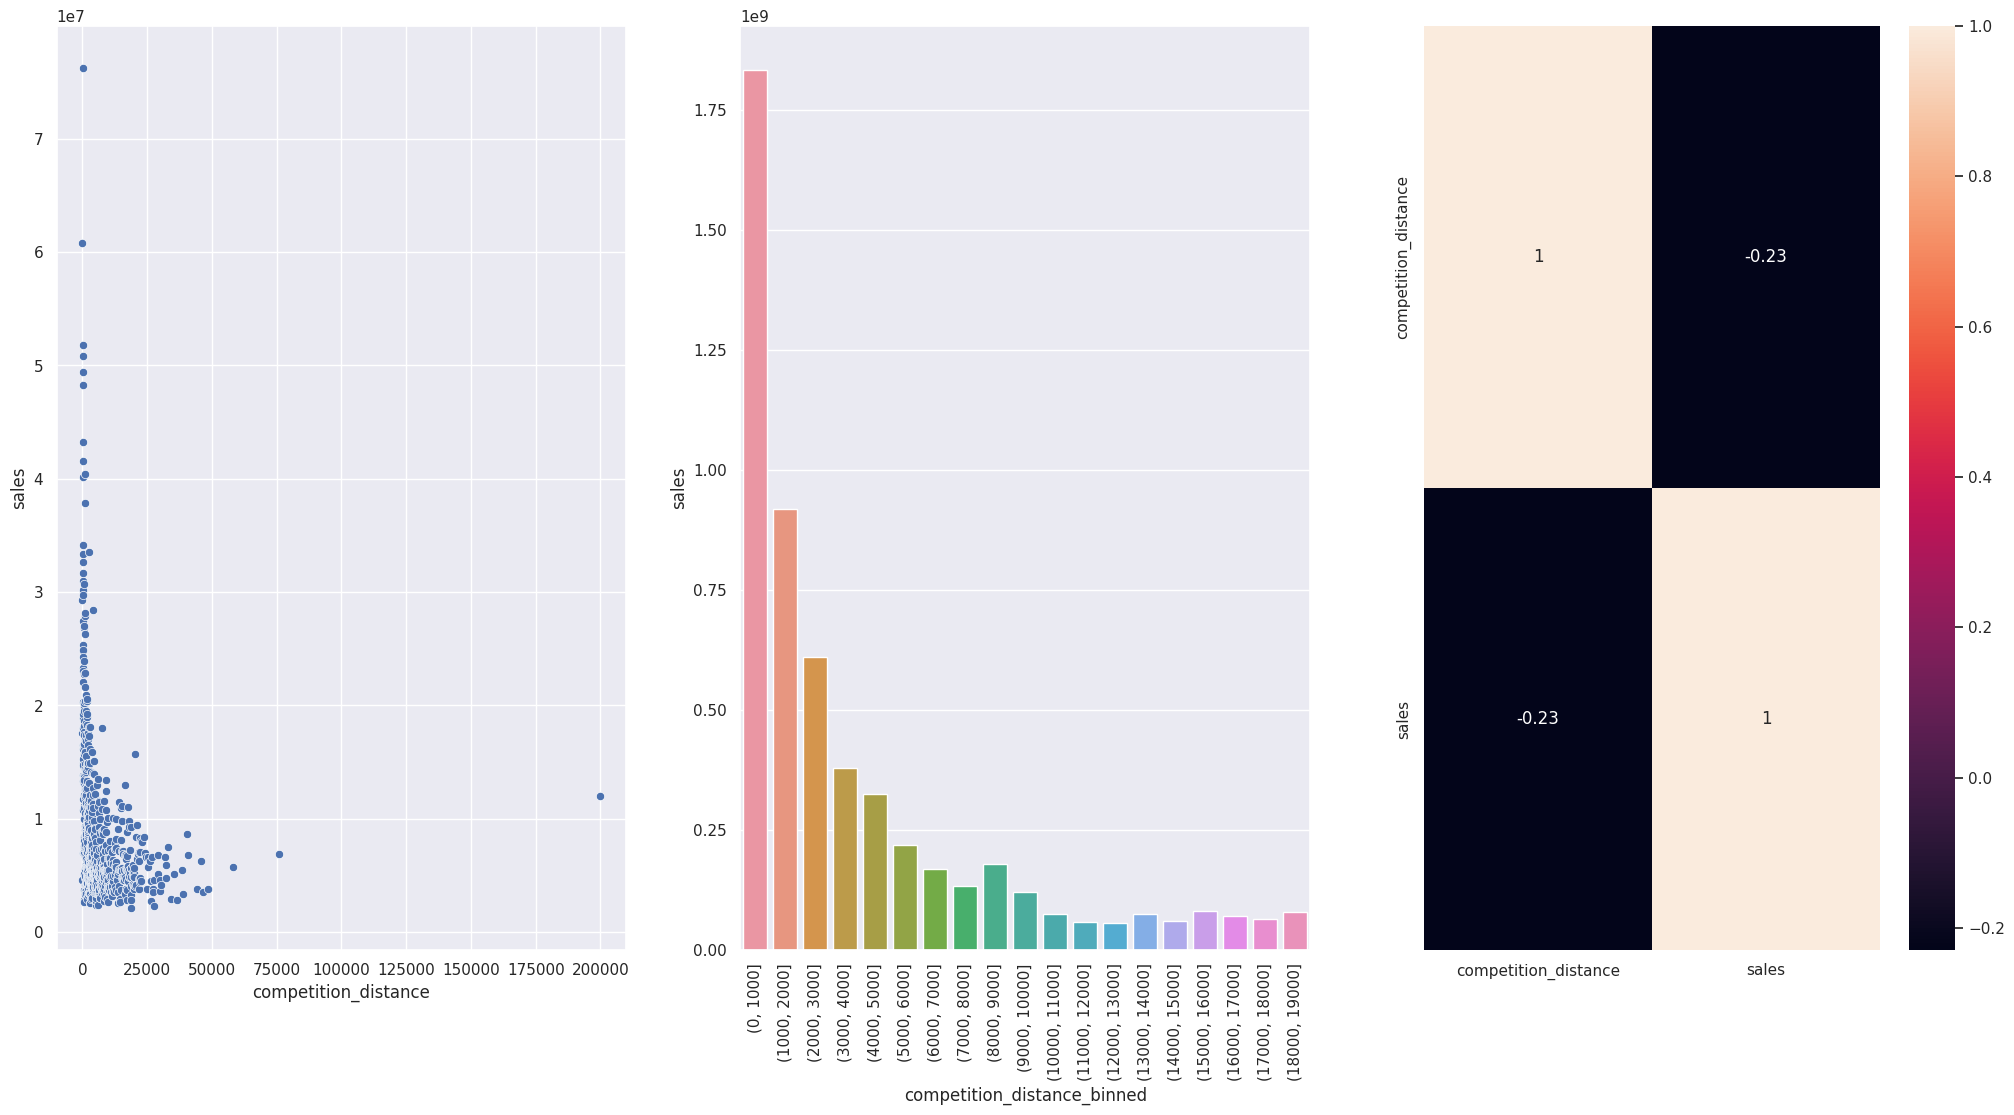

In [60]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
***FALSA**. Lojas com competidores a MAIS TEMPO vendem MENOS

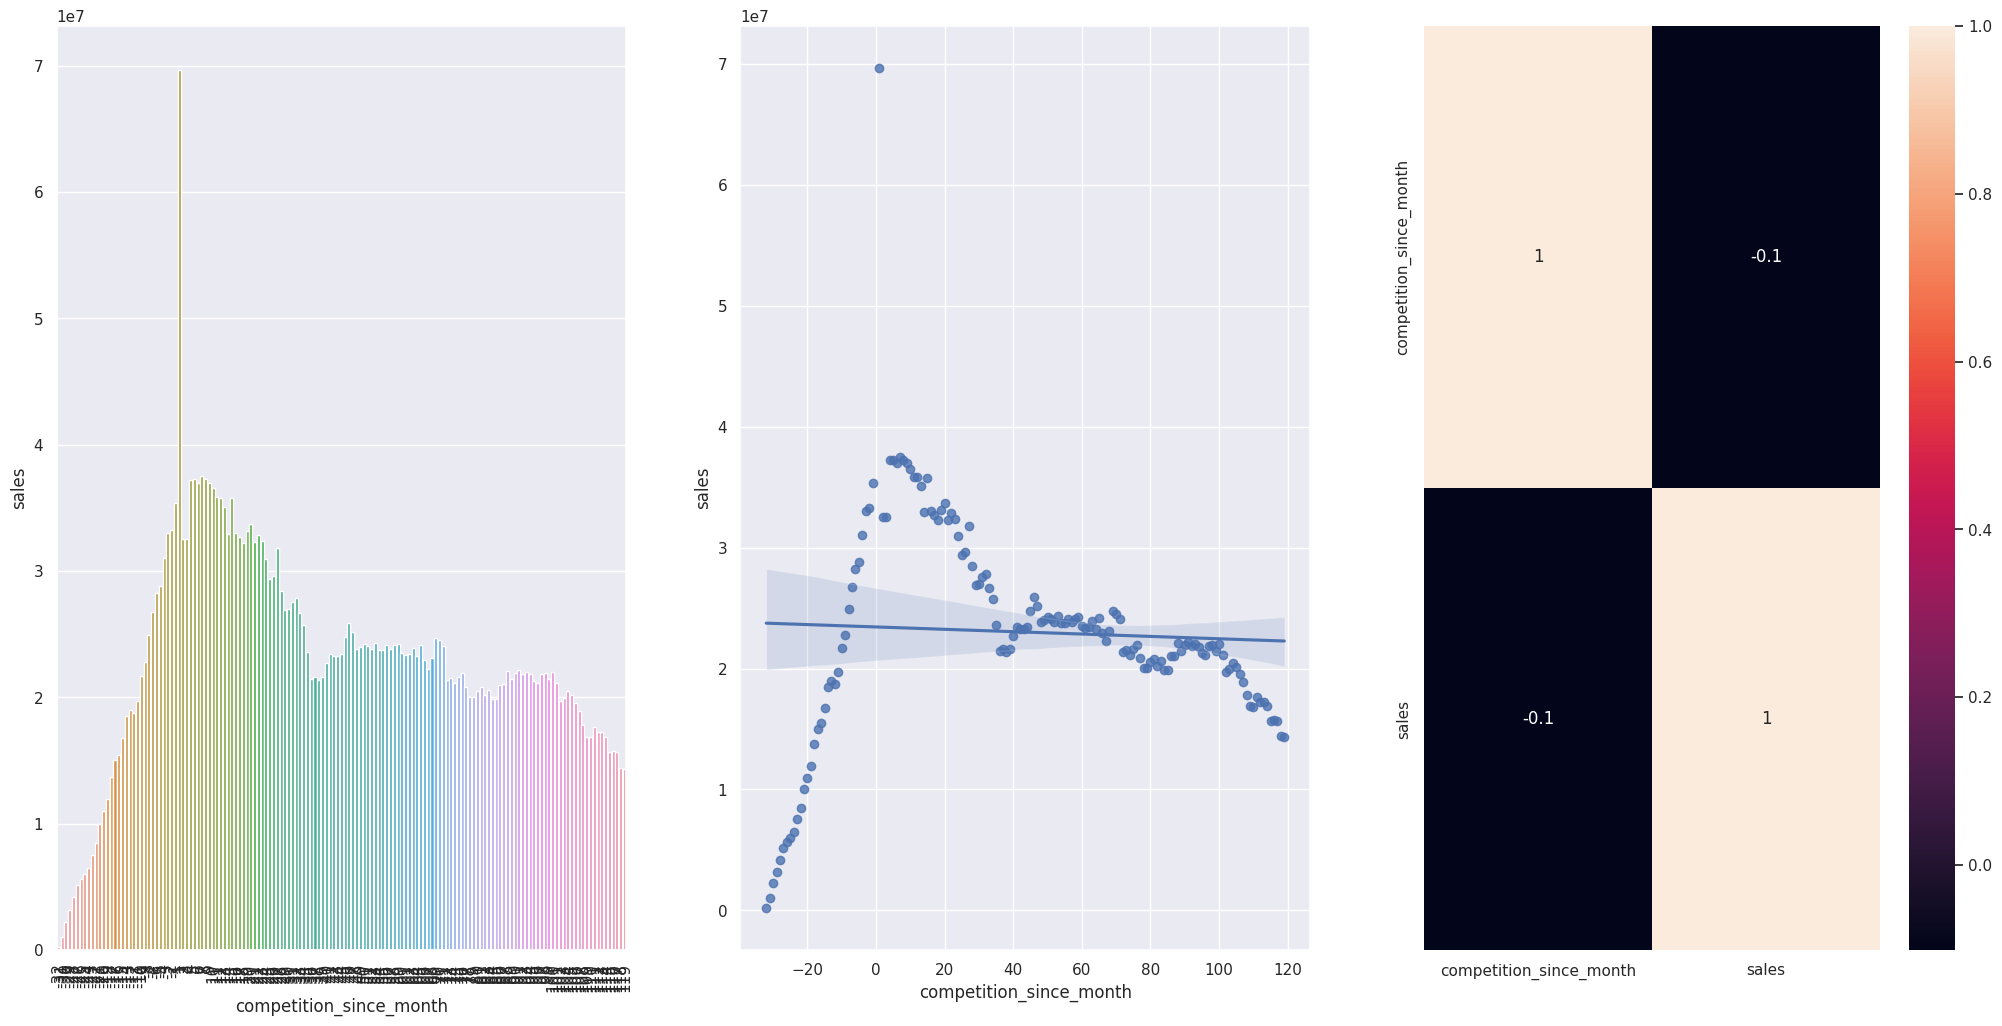

In [61]:
plt.subplot(1,3,1)
aux1 = df4[['competition_since_month','sales']].groupby('competition_since_month').sum().reset_index()
aux2 = aux1[(aux1['competition_since_month']<120) & (aux1['competition_since_month']!=0)]
sns.barplot(x='competition_since_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_since_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
***Falsa**. Lojas com promoção ativa por mais tempo vende menos depois de um certo tempo.

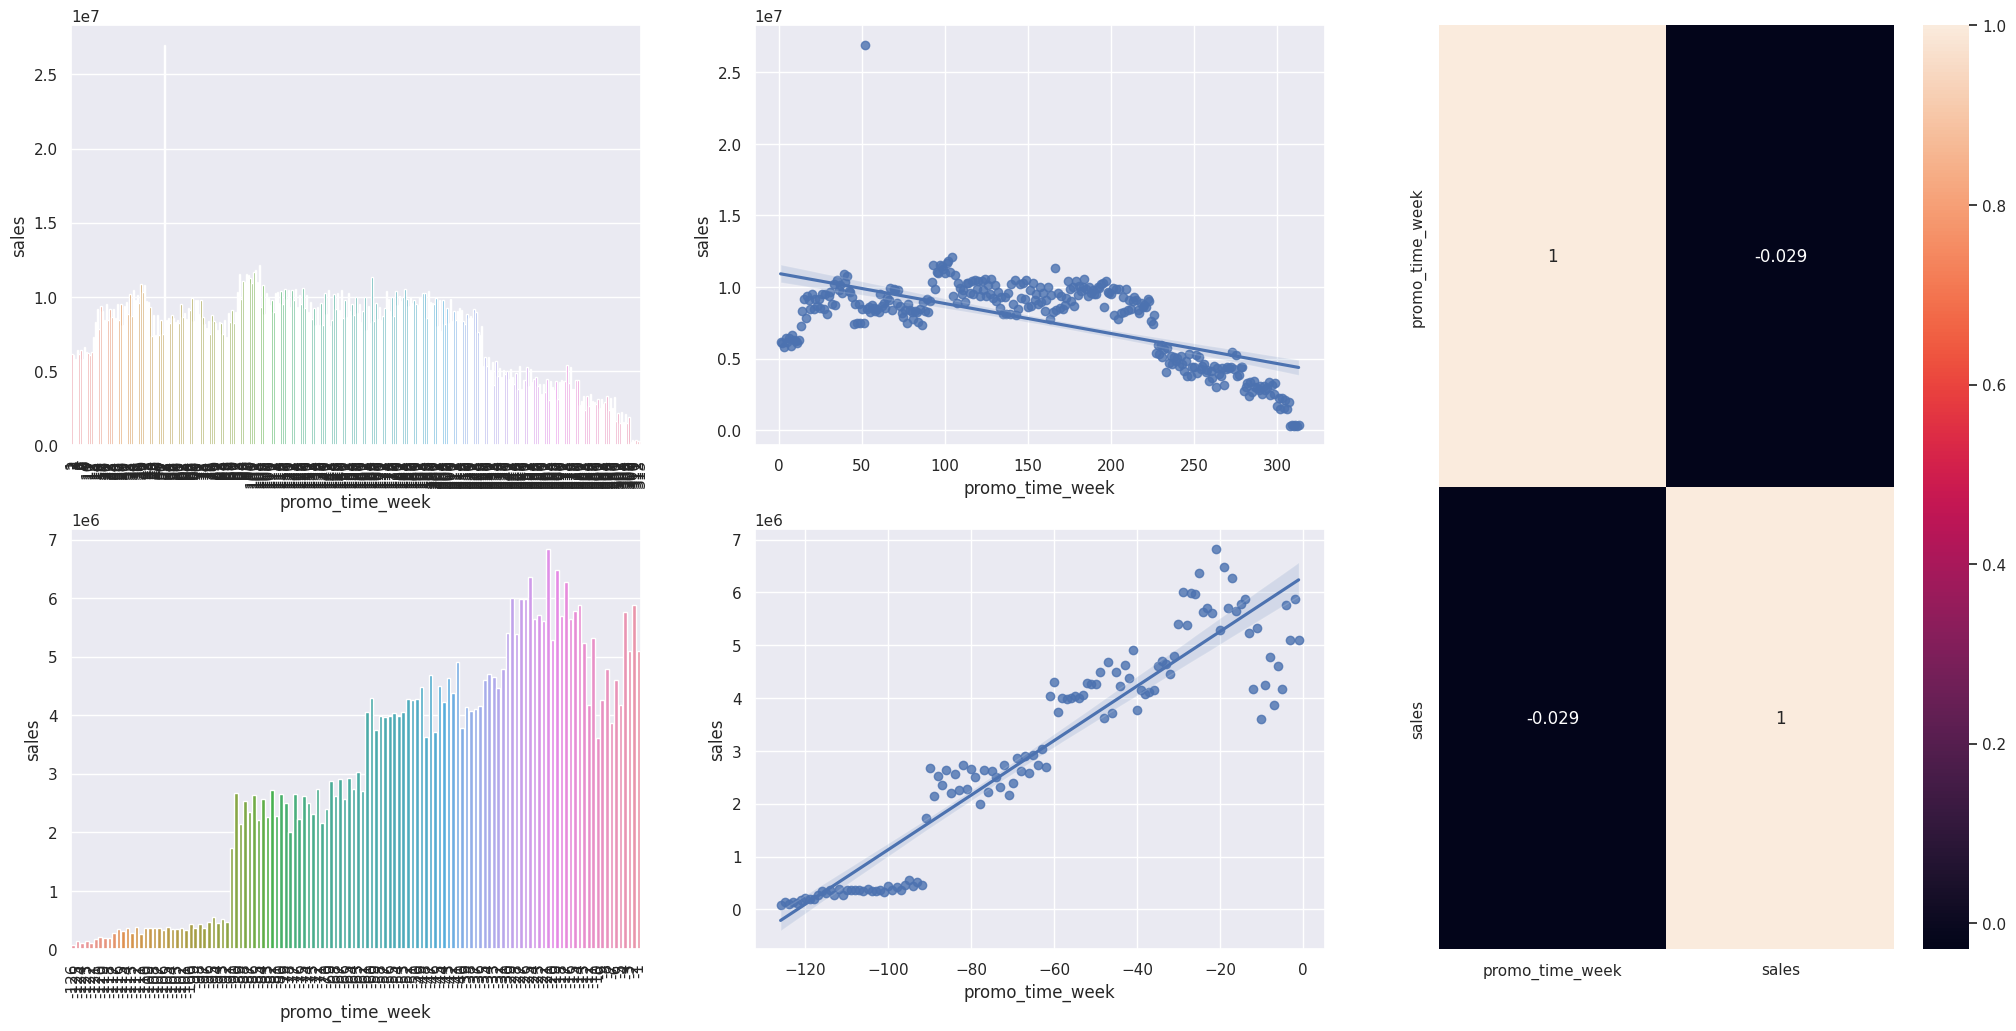

In [62]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extended
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo normal
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>


### H6. Lojas com mais promoções consecutivas deveriam vender mais.
***Falsa**. Lojas com promoções consecutivas vendem menos

In [63]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


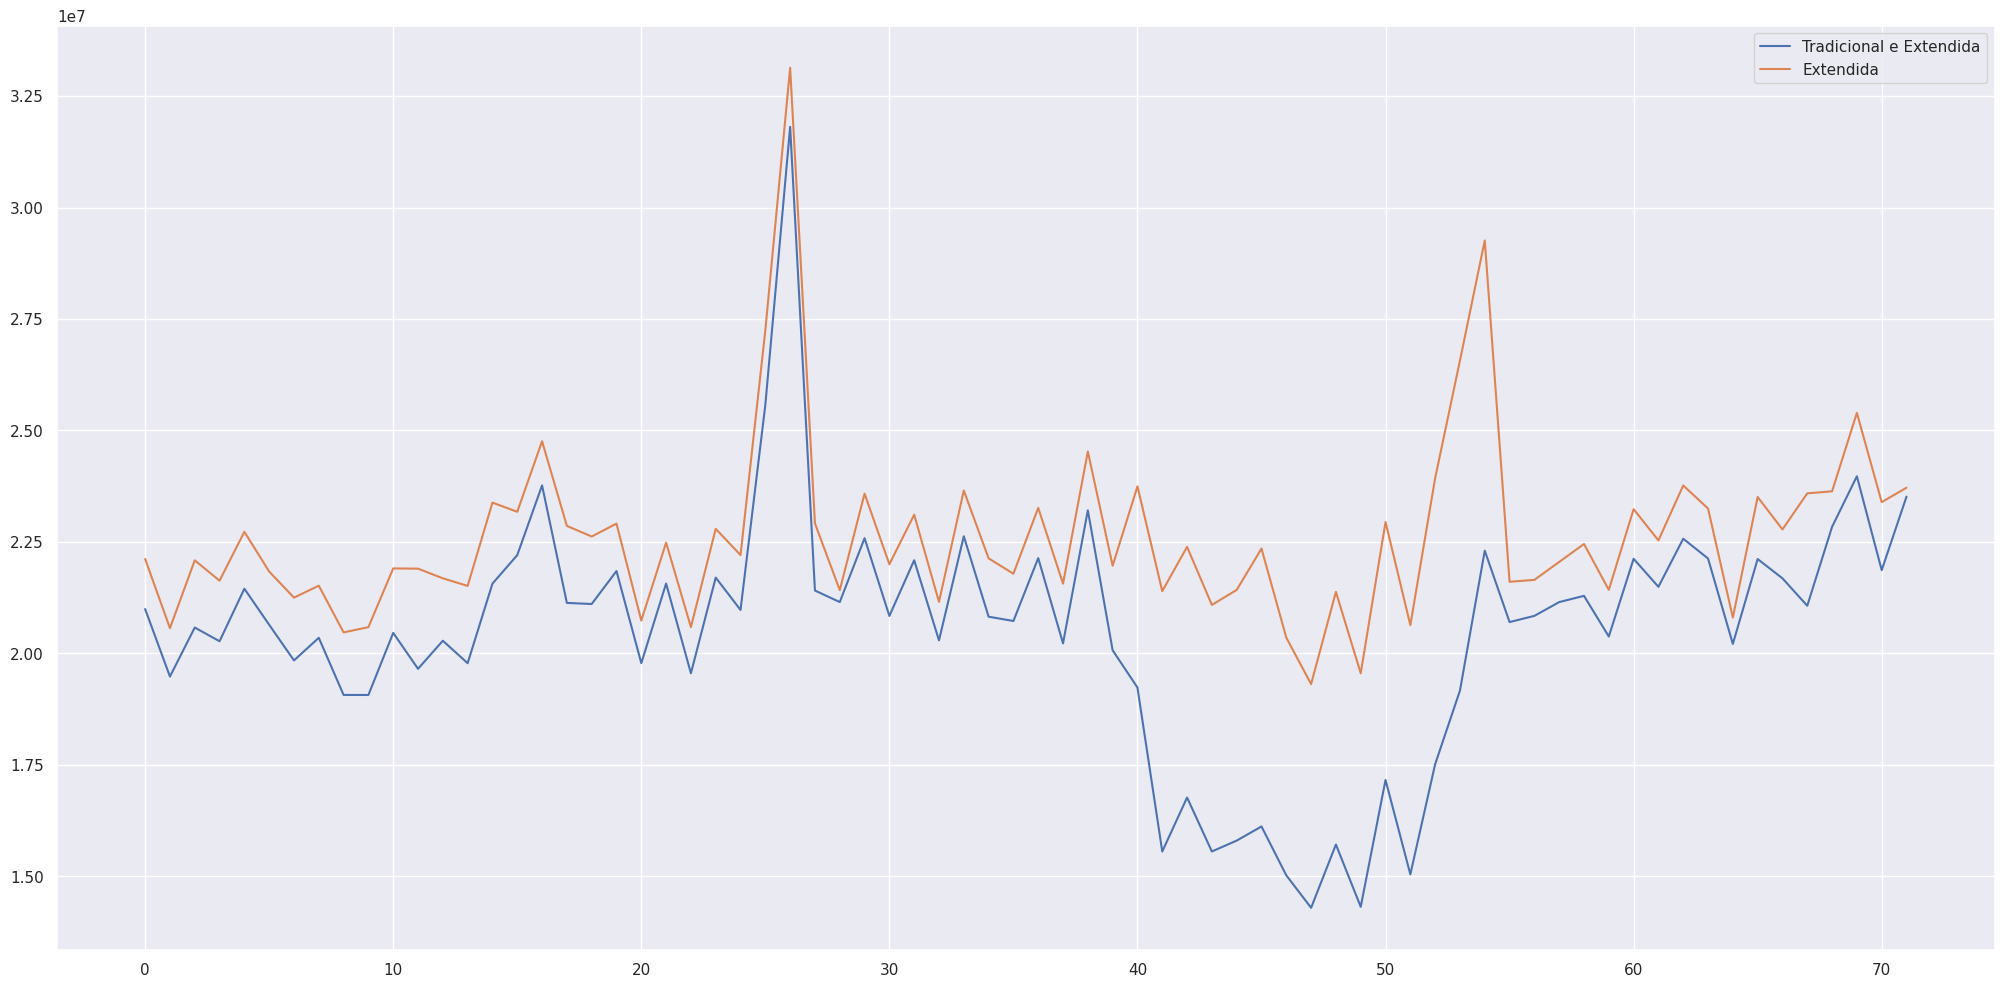

In [64]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida', 'Extendida']);


### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
***FALSA** Lojas abertas durante os feriados públicos vendem mais.


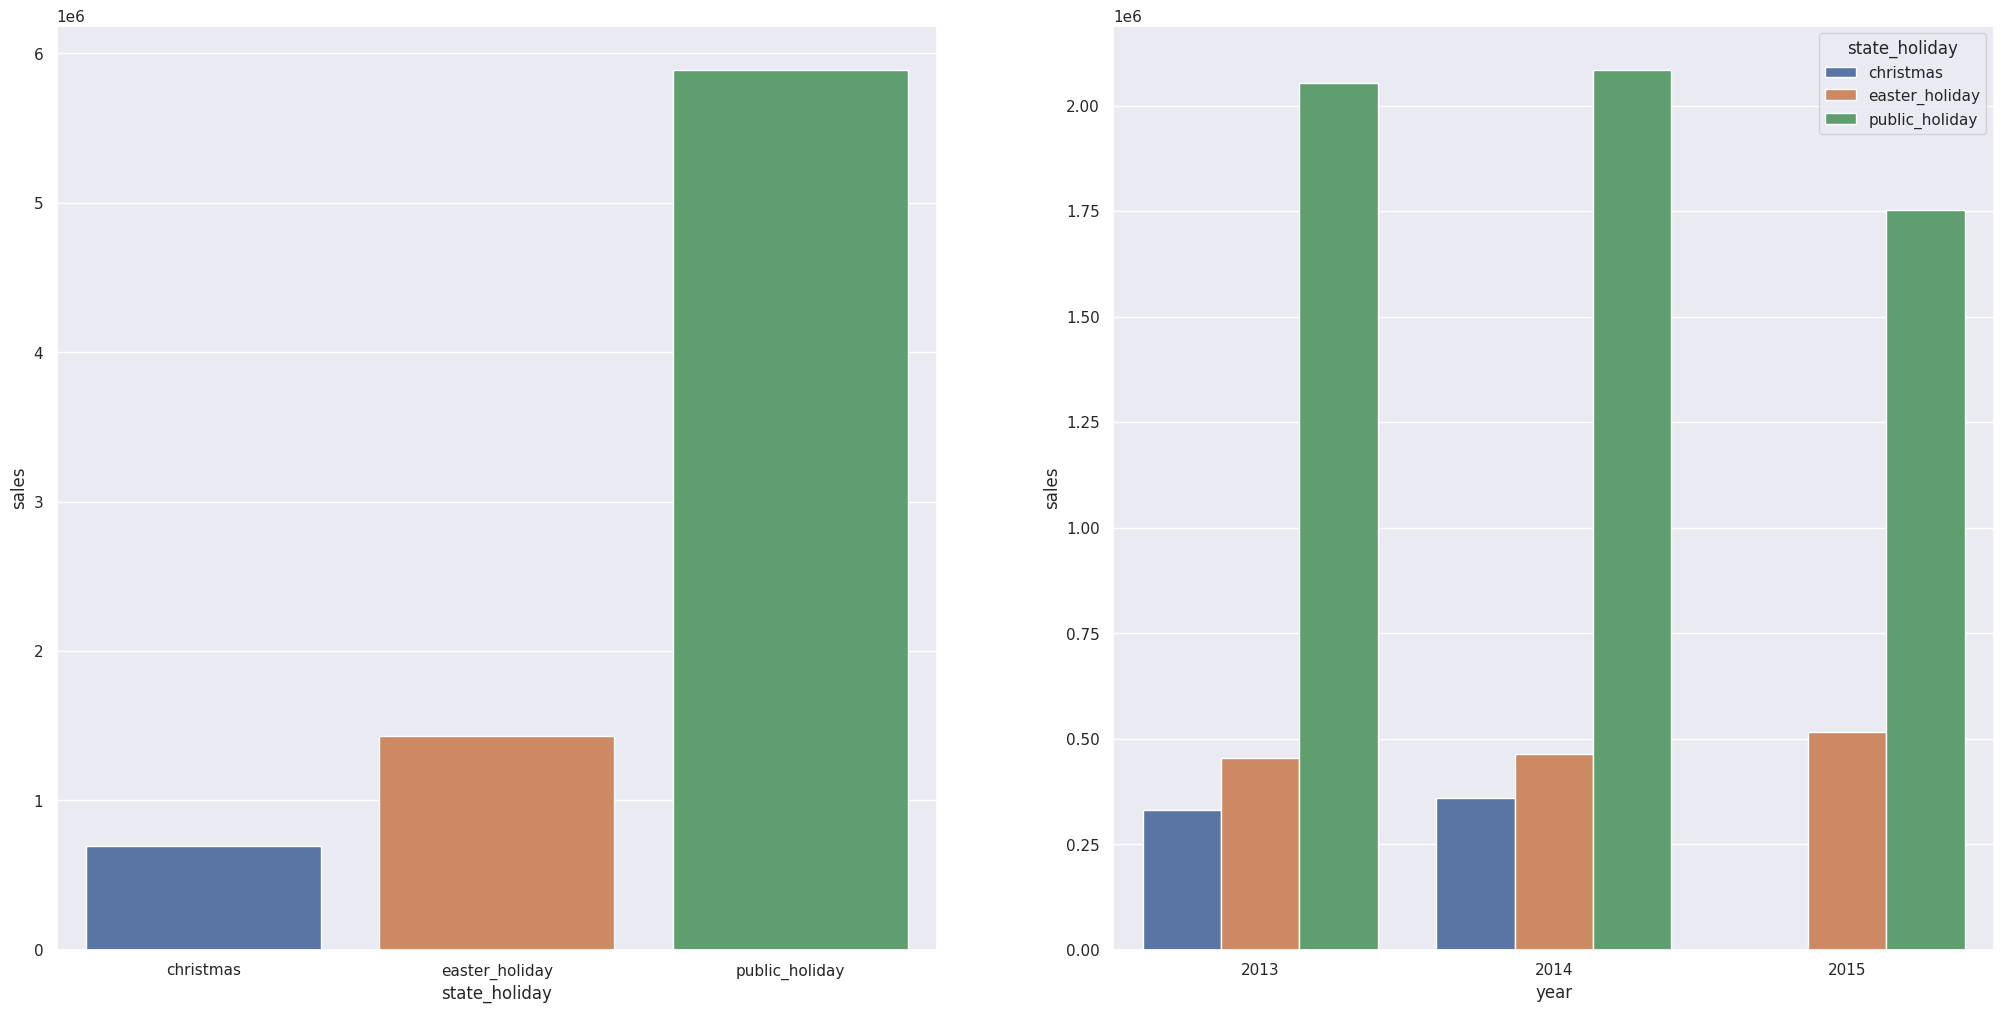

In [65]:
aux = df4[df4['state_holiday']!='regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['state_holiday','year','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
***FALSA** As lojas estão vendendo menos ao longo do ano

<AxesSubplot: >

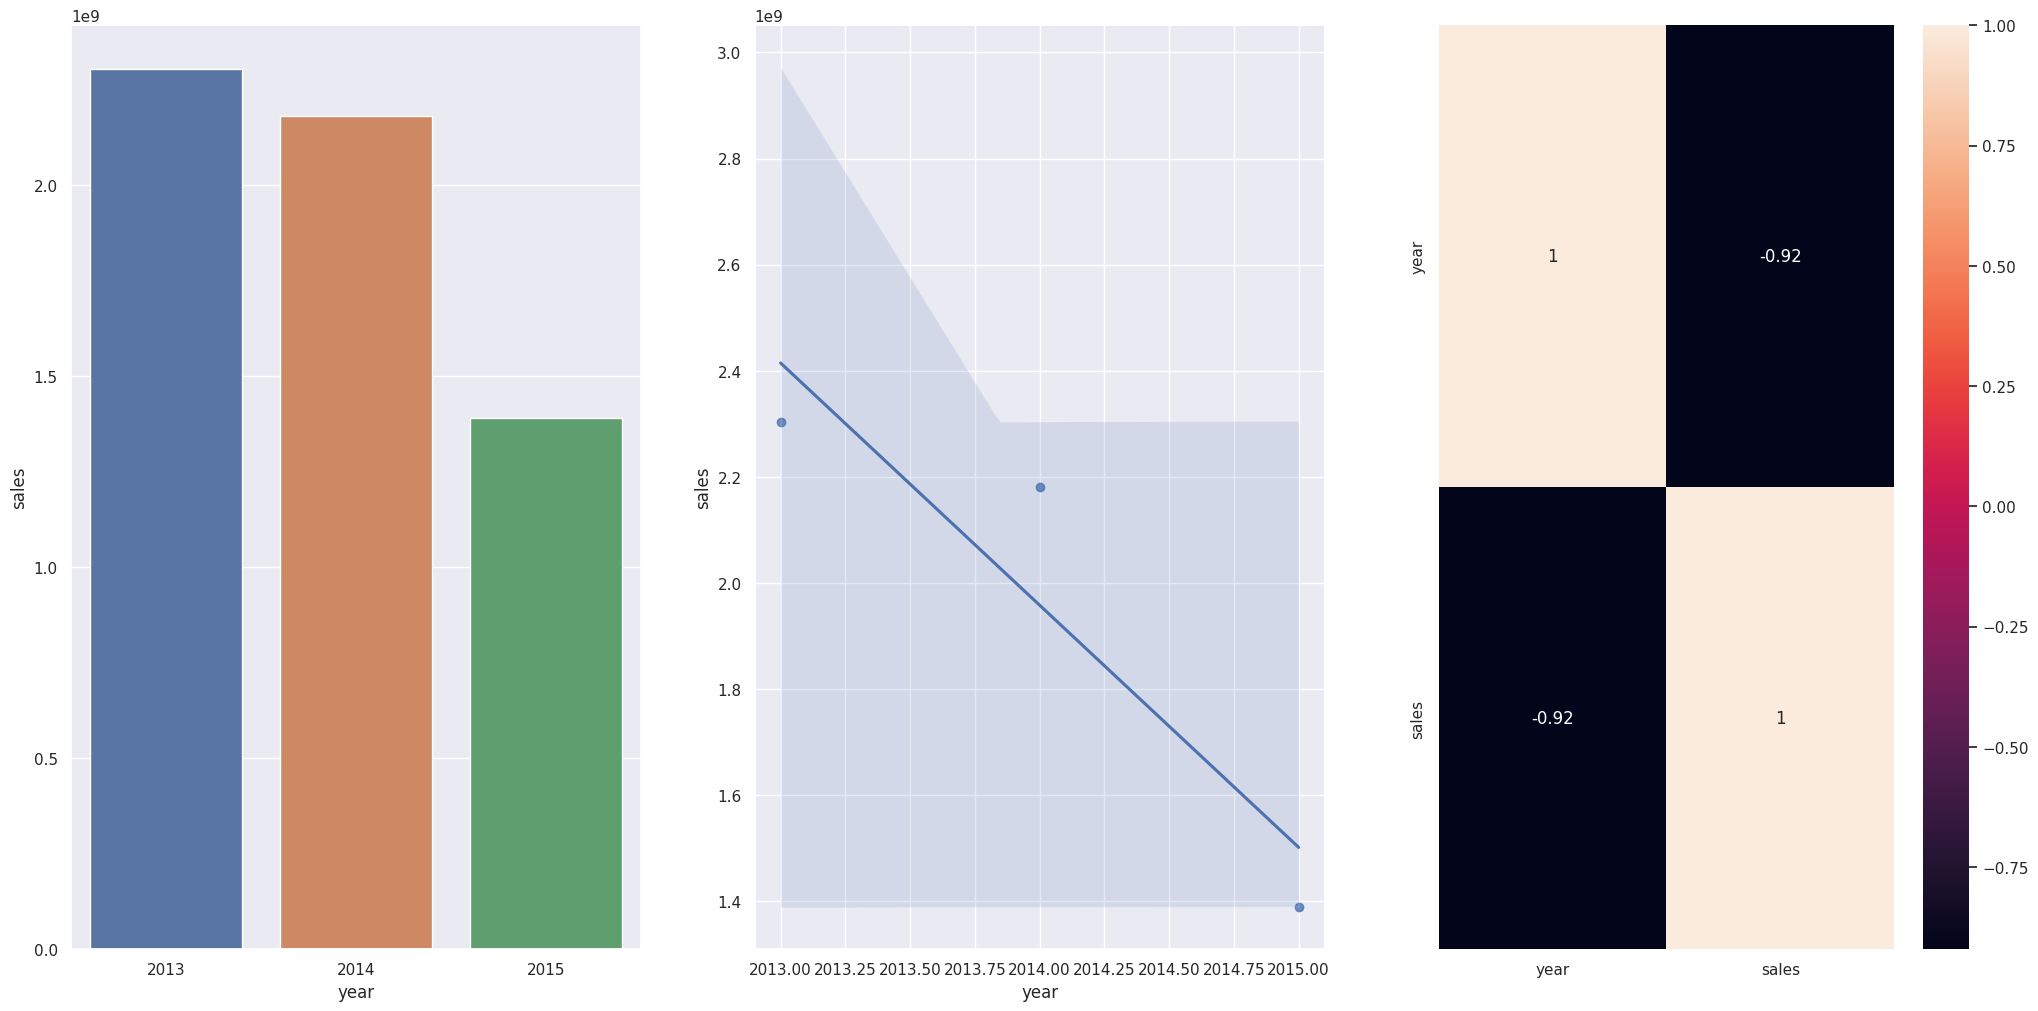

In [66]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H9. Lojas deveriam vender mais no segundo semestre do ano.
***FALSA** Lojas vendem menos no segundo semestre do ano

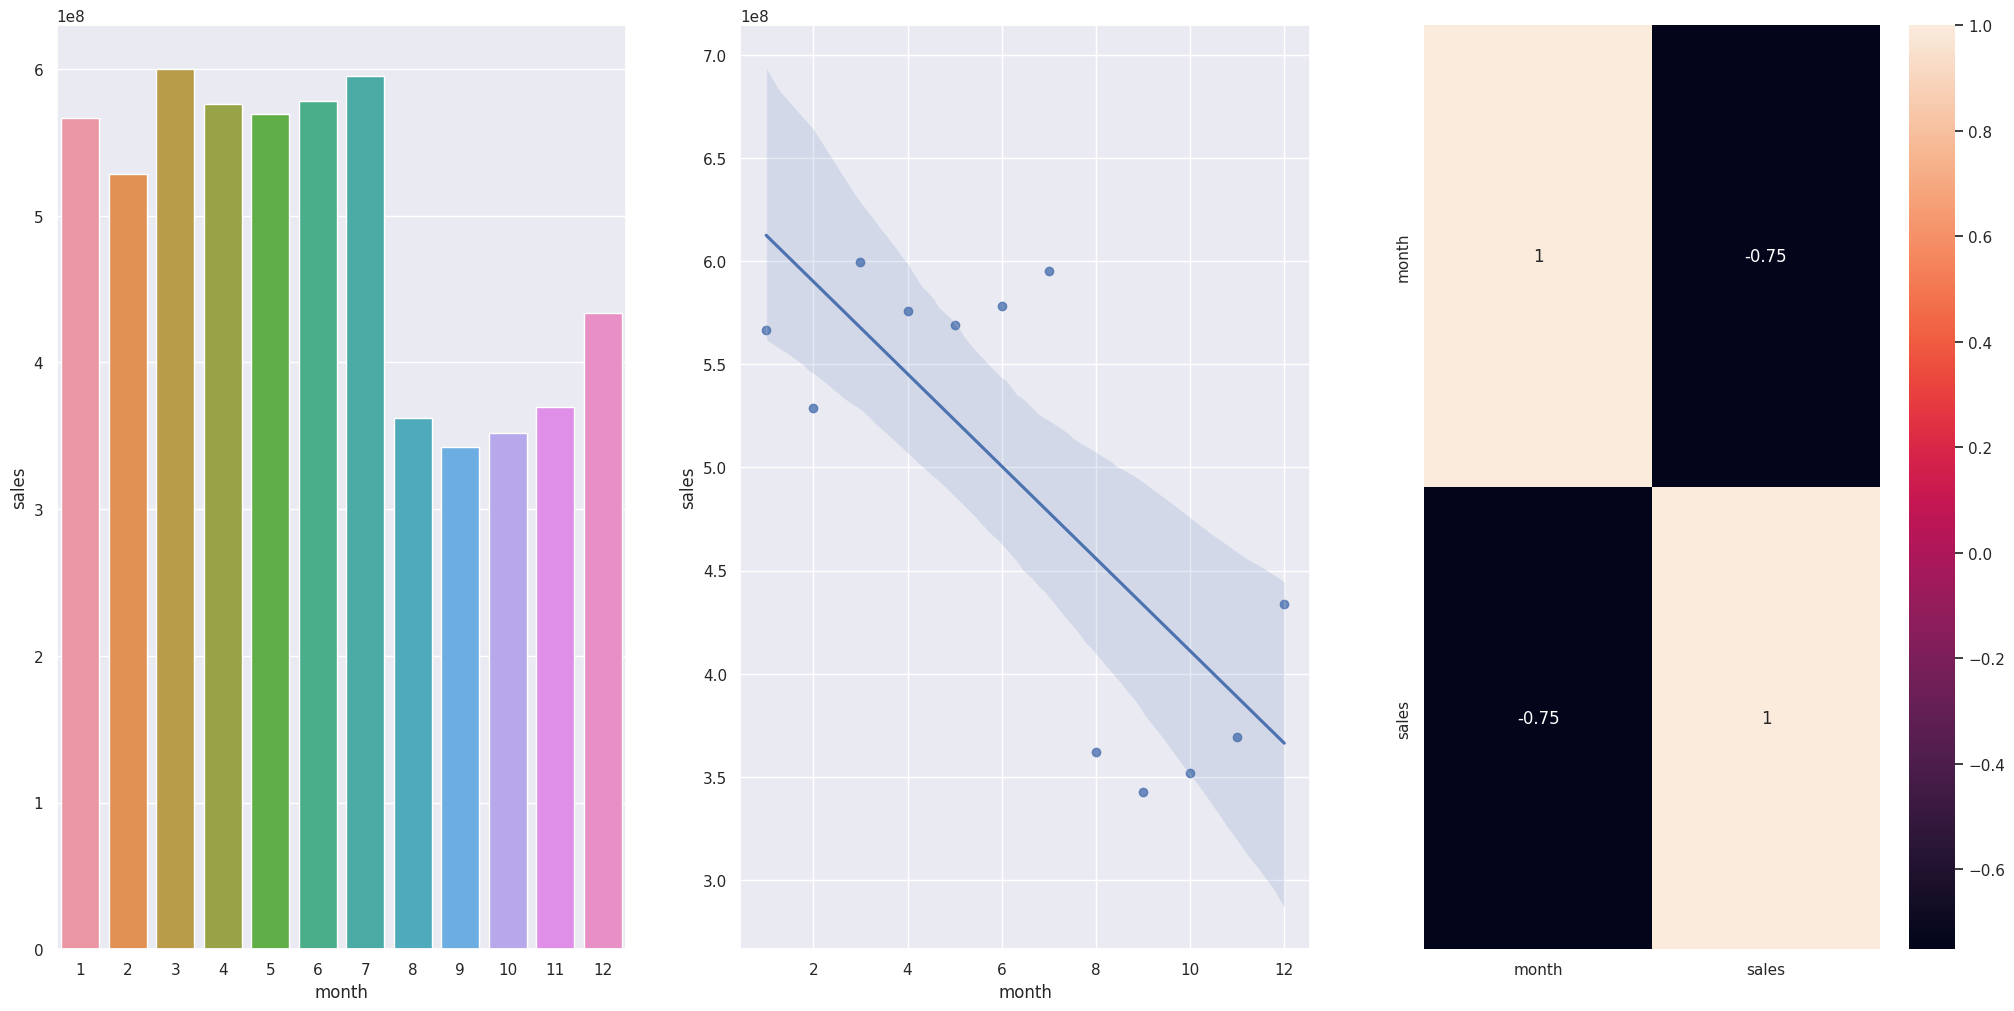

In [67]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
***VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês

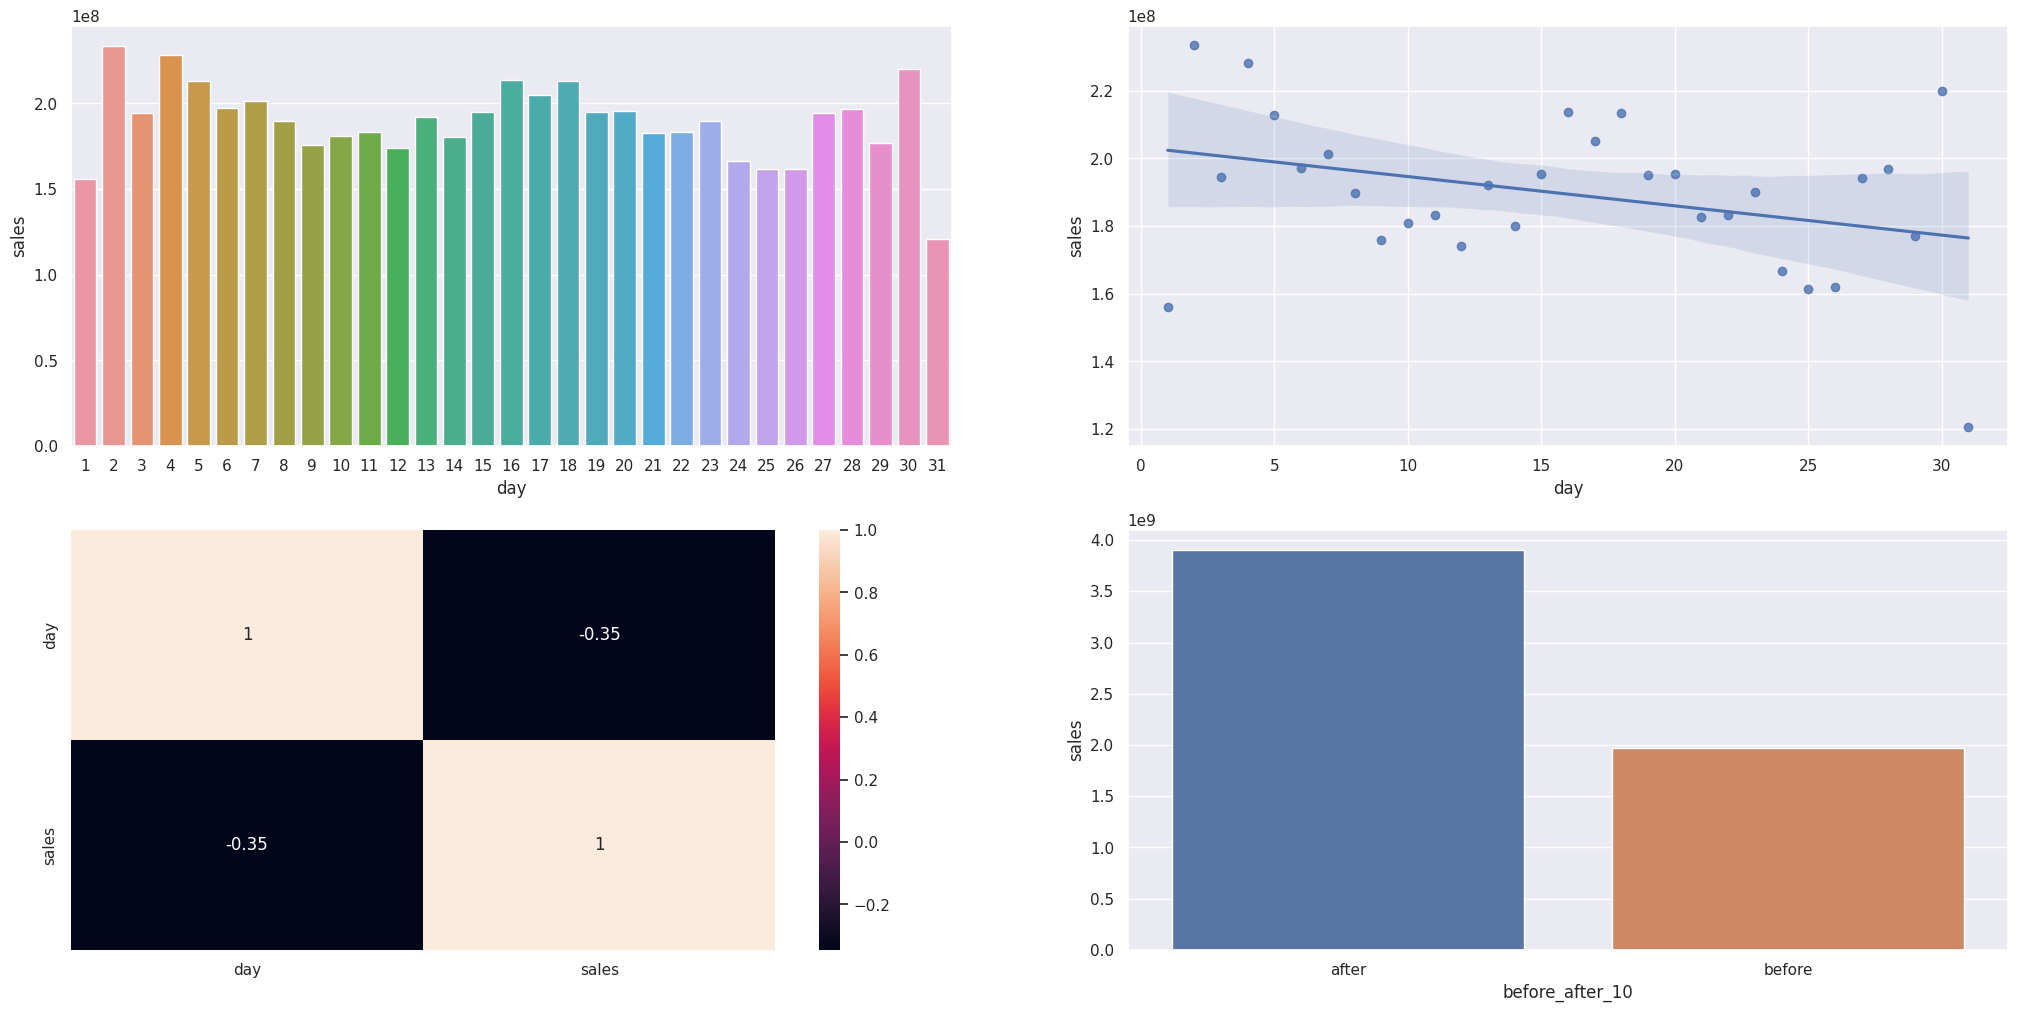

In [68]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


aux1['before_after_10'] = aux1['day'].apply(lambda x: 'before' if x <= 10 else 'after')
aux2 = aux1[['before_after_10','sales']].groupby('before_after_10').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x='before_after_10',y='sales', data=aux2);



### H11. Lojas deveriam vender menos aos finais de semana.
***VERDADEIRA** Lojas vendem menos nos finais de semana. 


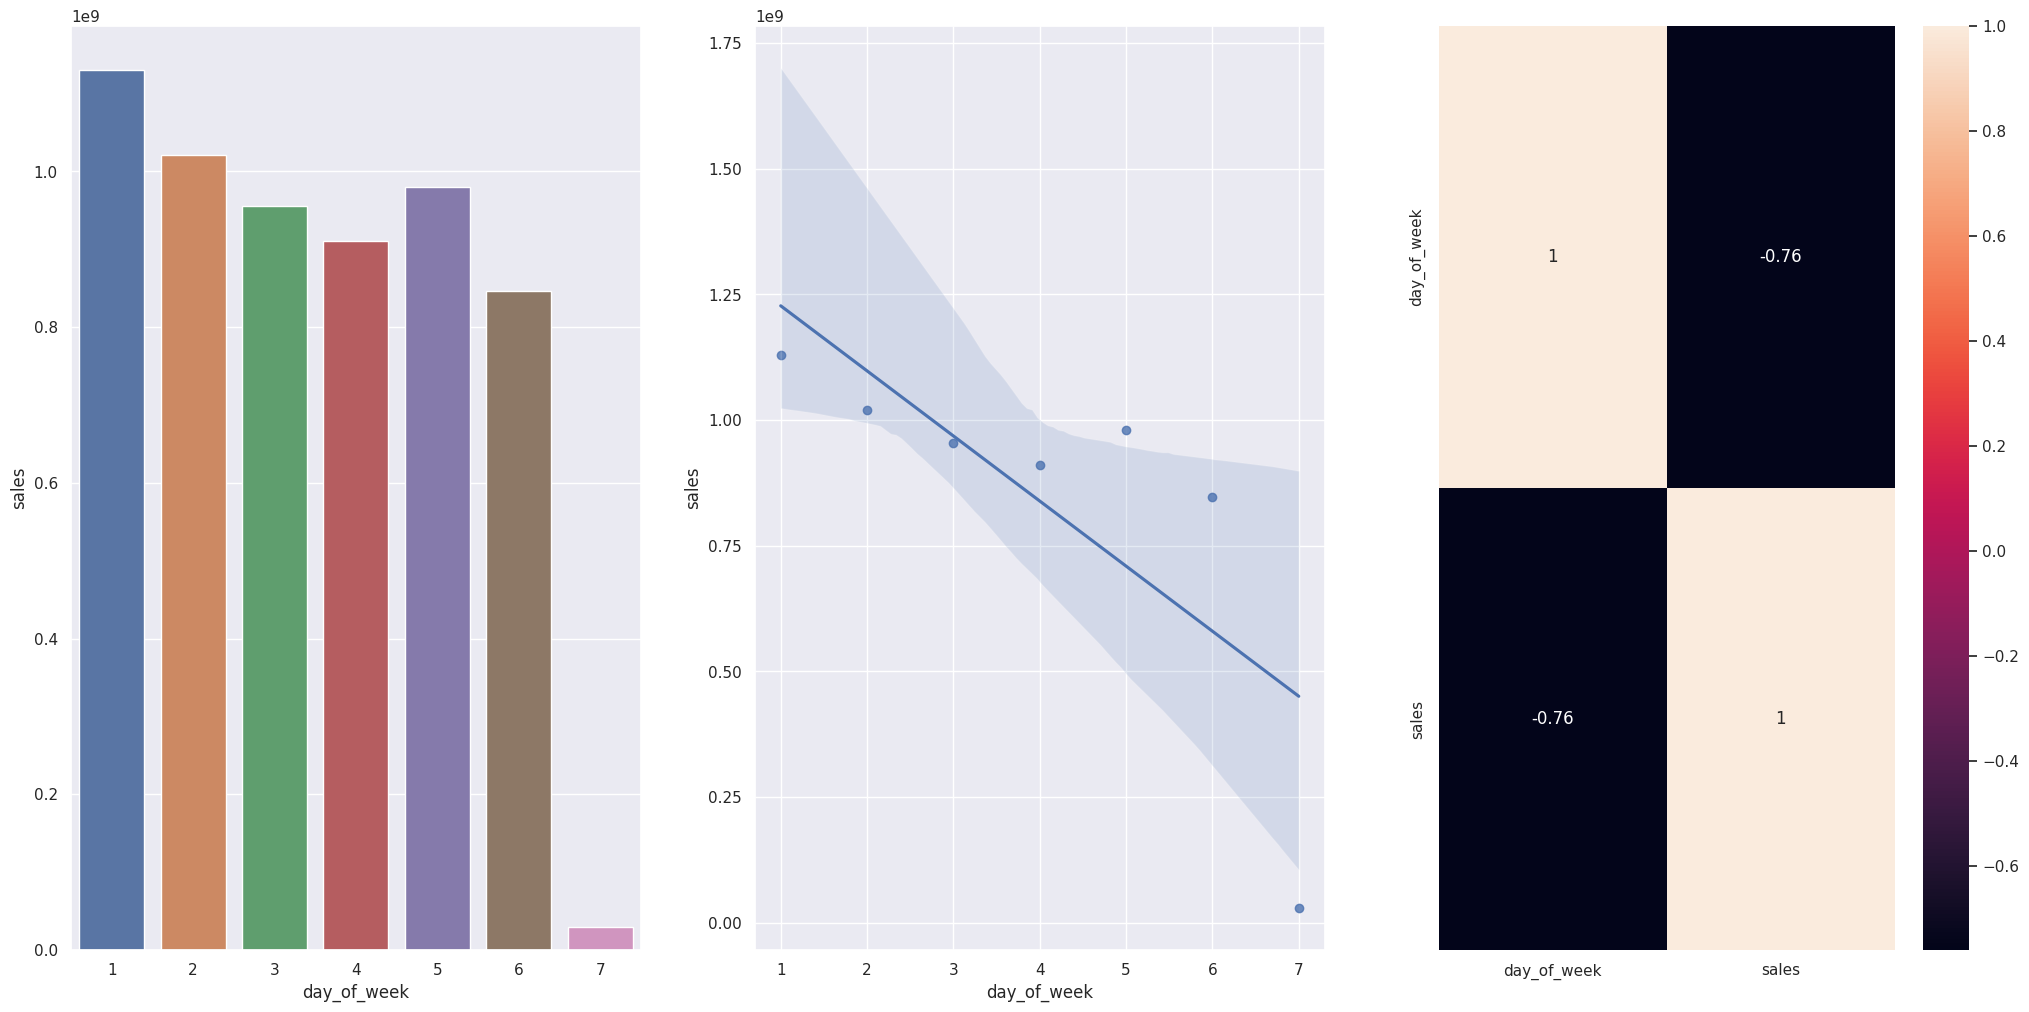

In [69]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
***VERDADEIRA** Lojas vendem menos durante os feriados ecolares, exceto os meses de **Julho** e **Agosto**

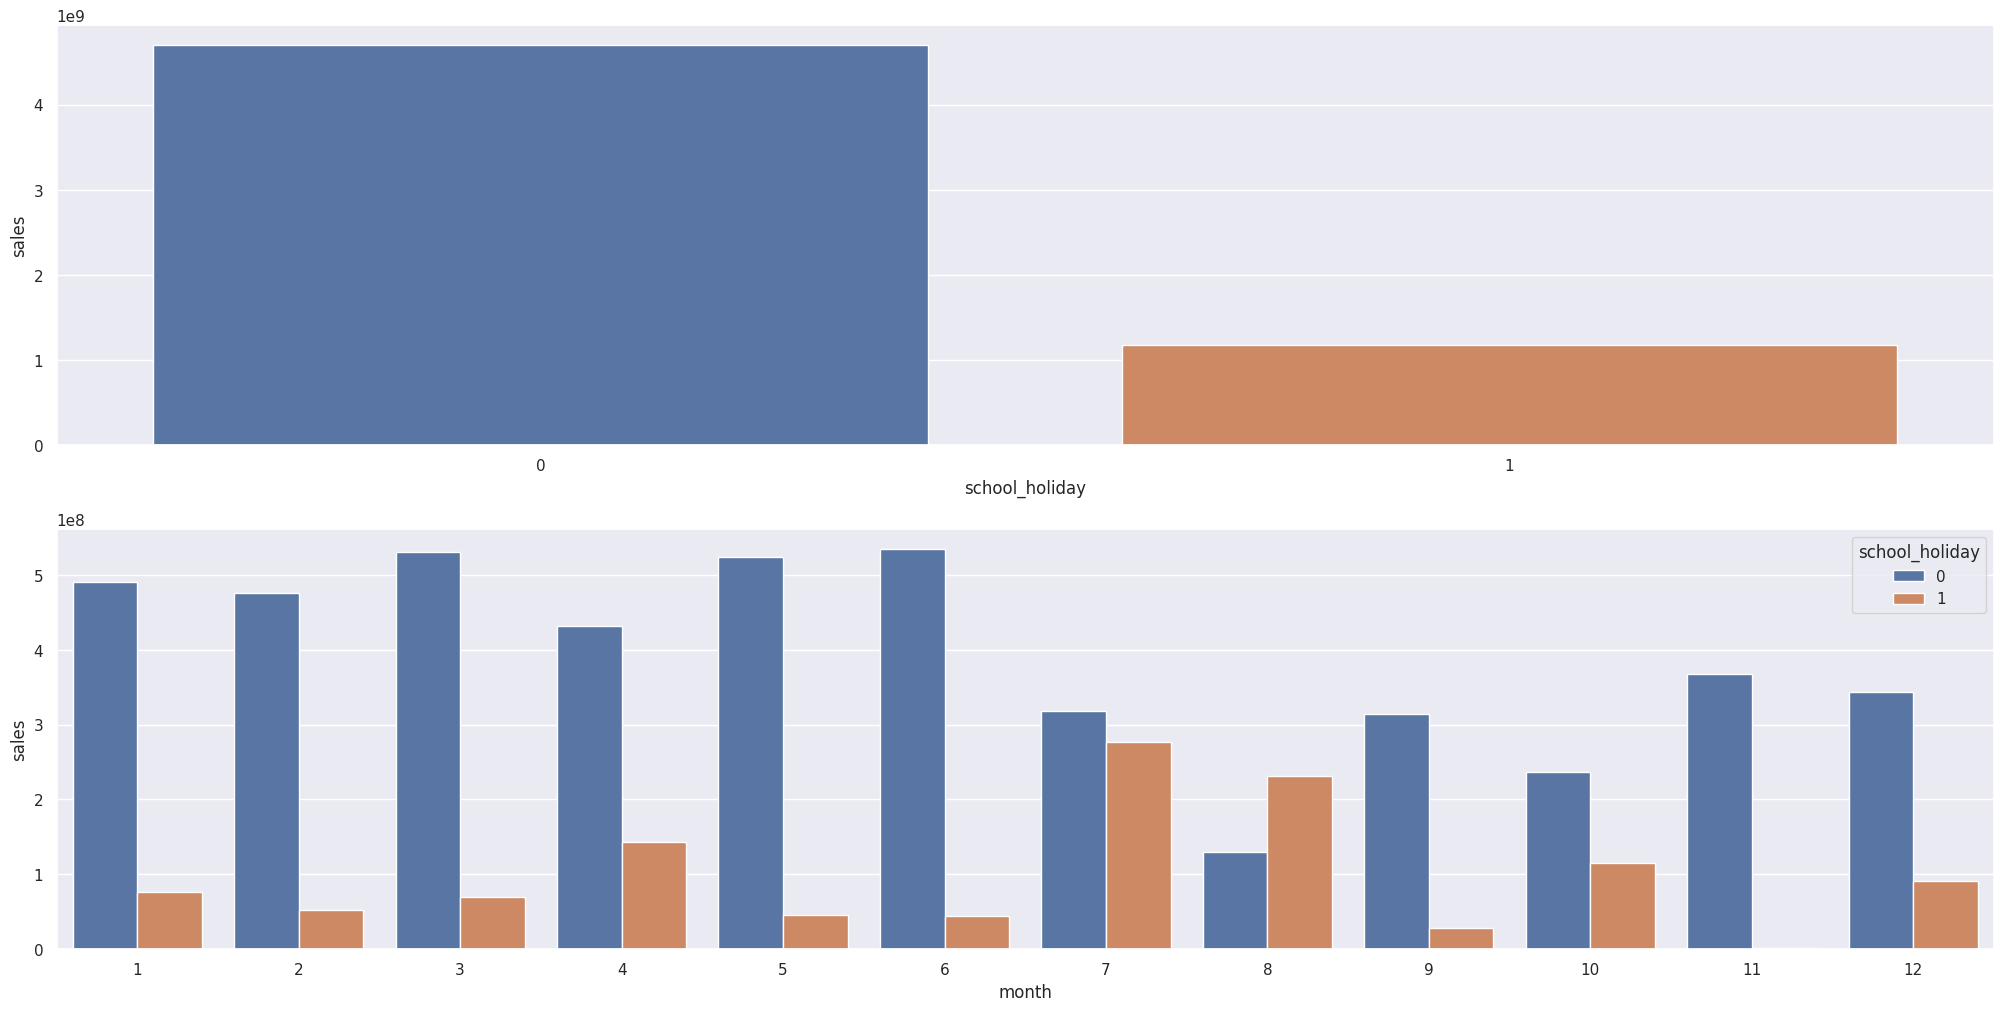

In [70]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## 4.2.1 Resumo das Hipóteses

In [71]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

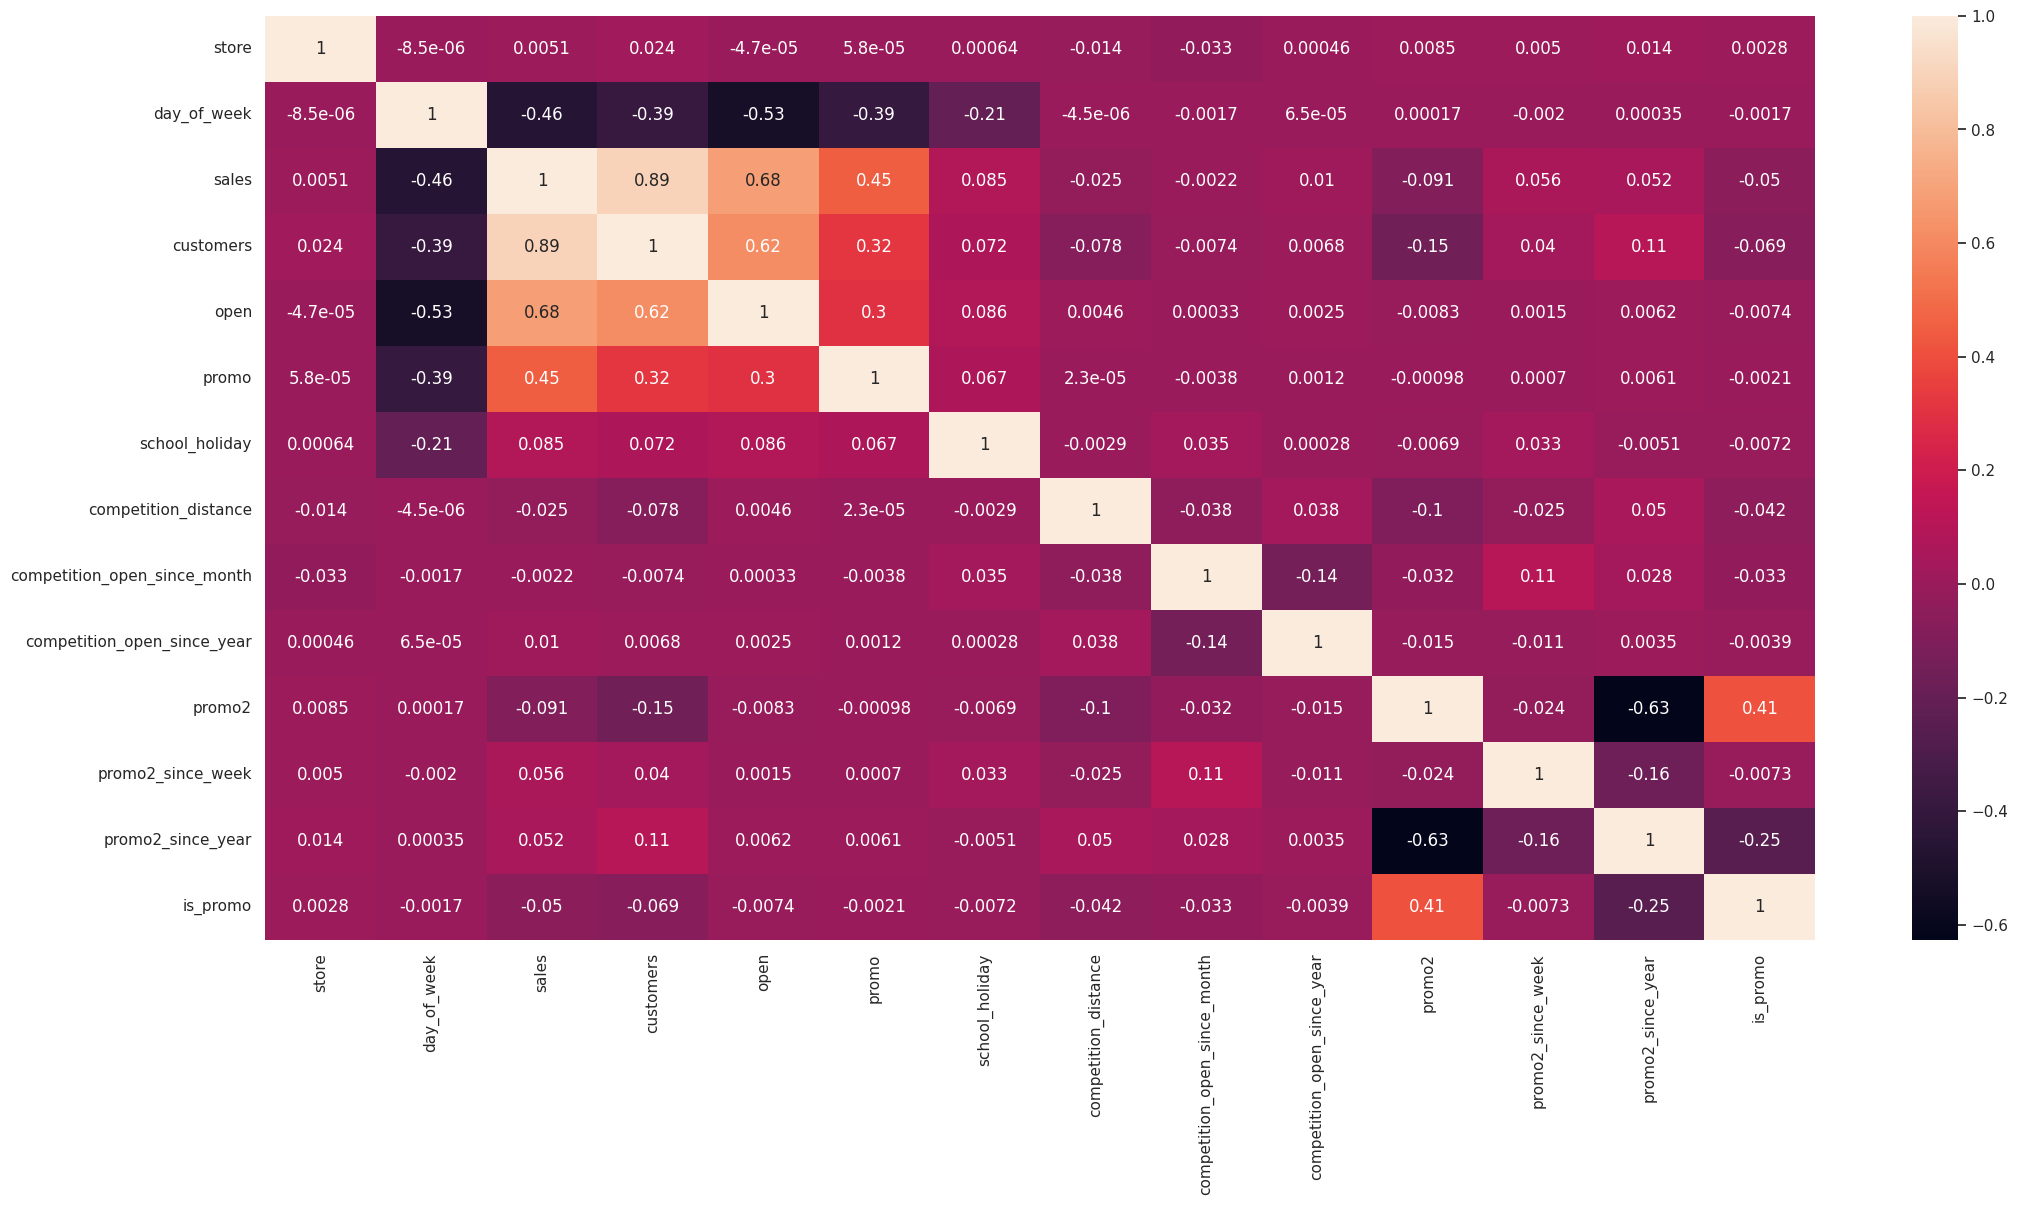

In [76]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

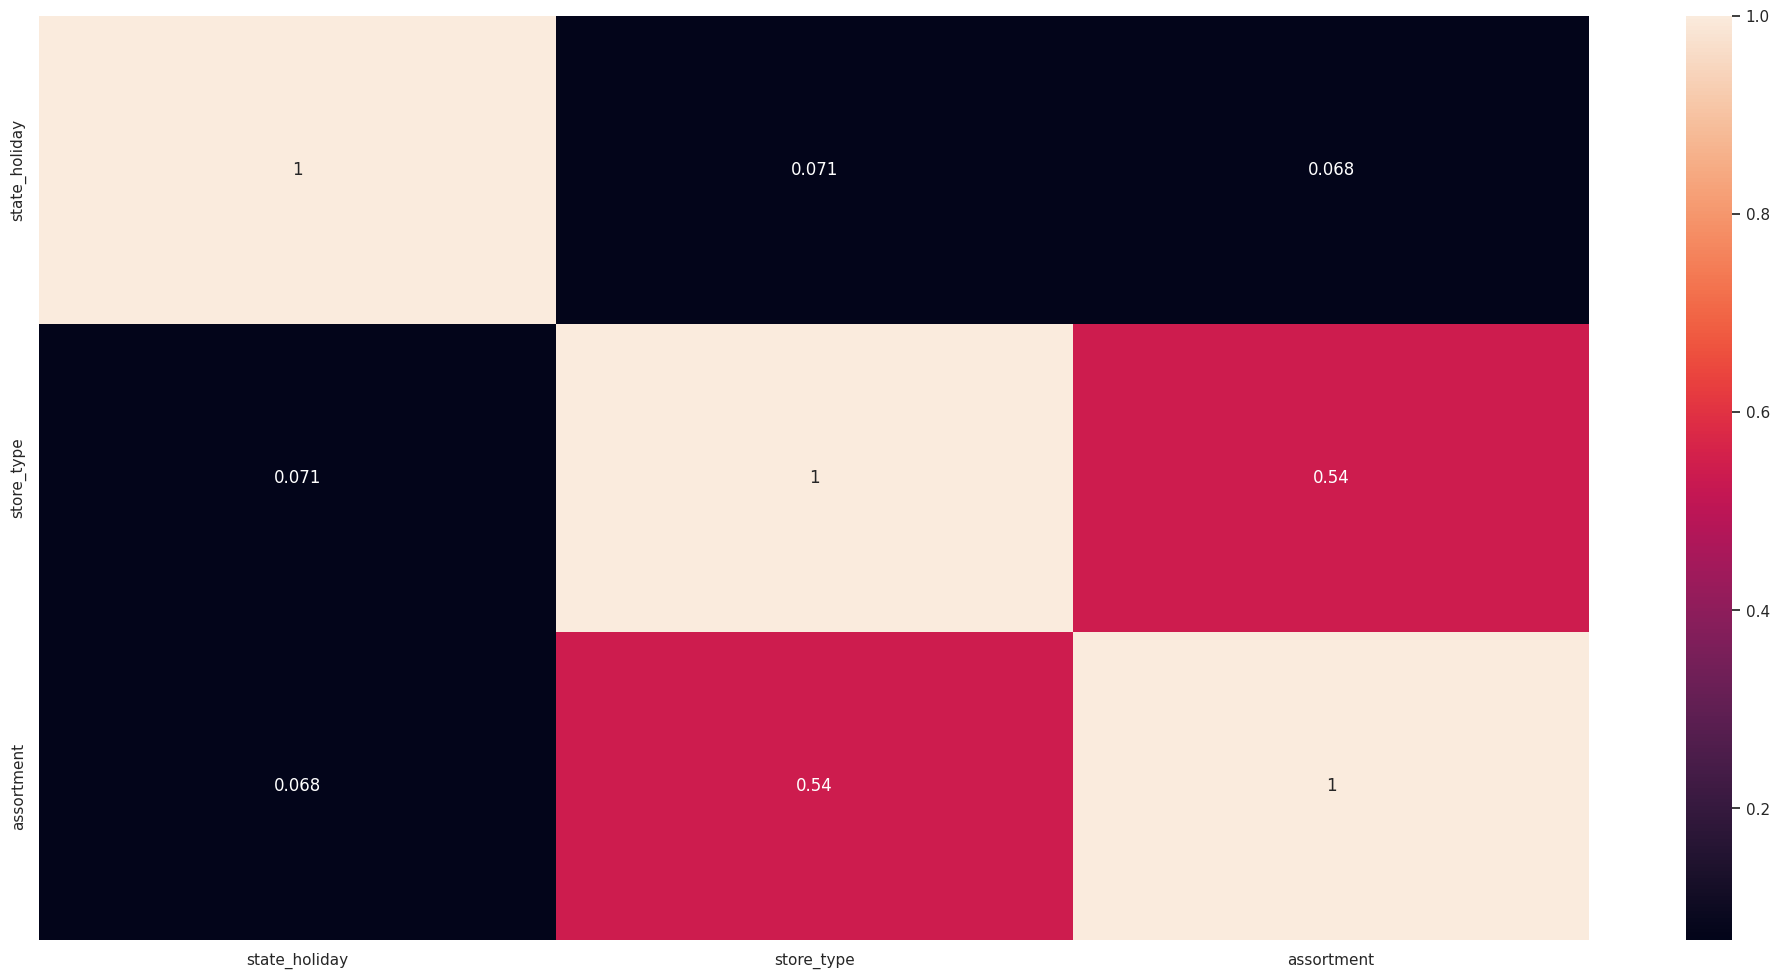

In [119]:
a = df4.select_dtypes(include='object')

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3], 'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9] } )
d = d.set_index(d.columns)

sns.heatmap( d, annot=True);